In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torchvision.utils import save_image

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import glob
from PIL import Image

import os
import pandas as pd
from torchvision.io import read_image

from torch.autograd import Variable

In [28]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

#Number of epochs for training
n_epochs = 1000

#Batch size
size_batch = 128

In [29]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.data = []
        for img_path in glob.glob(img_dir + "\\*.png"):
            self.data.append(img_path)
        #print(self.data)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = torchvision.transforms.functional.to_tensor(Image.open(img_path))
        #label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label = np.float32(1)
        return (image, label)

In [30]:
images = CustomImageDataset(img_dir = "C:\\Users\\bocir\\OneDrive\\Desktop\\FaceGen\\data")

In [31]:
train_dataloader = data.DataLoader(images, batch_size = size_batch, shuffle = True, drop_last = True)

Feature batch shape: torch.Size([3, 64, 64])
shape: torch.Size([3, 64, 64])


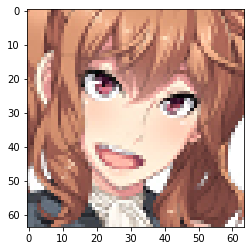

In [32]:
train_features,_ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features[0].size()}")
img = train_features[0]
print(f"shape: {img.size()}")
plt.imshow(np.swapaxes(np.swapaxes(img,0,2), 0, 1))

In [33]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf, ndf):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.n1 = nn.BatchNorm2d(ngf * 8)
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.n2 = nn.BatchNorm2d(ngf * 4)
        self.conv3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.n3 = nn.BatchNorm2d(ngf * 2)
        self.conv4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.n4 = nn.BatchNorm2d(ngf)
        self.conv5 = nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)

    def forward(self, input):
        out = self.conv1(input)
        out = self.n1(out)
        out = torch.nn.functional.relu(out)
        out = self.conv2(out)
        out = self.n2(out)
        out = torch.nn.functional.relu(out)
        out = self.conv3(out)
        out = self.n3(out)
        out = torch.nn.functional.relu(out)
        out = self.conv4(out)
        out = self.n4(out)
        out = torch.nn.functional.relu(out)
        out = self.conv5(out)
        out = torch.tanh(out)
        
        return out
    
class Discriminator(nn.Module):
    def __init__(self, nc, nz, ngf, ndf):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.n1 = nn.BatchNorm2d(ndf)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.n2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.n3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.n4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        out = self.conv1(input)
        out = self.n1(out)
        out = torch.nn.functional.leaky_relu(out, negative_slope=0.02, inplace=True)
        out = self.conv2(out)
        out = self.n2(out)
        out = torch.nn.functional.leaky_relu(out, negative_slope=0.02, inplace=True)
        out = self.conv3(out)
        out = self.n3(out)
        out = torch.nn.functional.leaky_relu(out, negative_slope=0.02, inplace=True)
        out = self.conv4(out)
        out = self.n4(out)
        out = torch.nn.functional.leaky_relu(out, negative_slope=0.02, inplace=True)
        out = self.conv5(out)
        out = out.flatten()
        out = torch.sigmoid(out)
        
        return out

In [34]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(nc, nz, ngf, ndf)
discriminator = Discriminator(nc, nz, ngf, ndf)

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.1)

In [24]:
# Lists to keep track of progress
G_losses = []
D_losses = []

#Training

for epoch in range(n_epochs):
    for i, (imgs, valid) in enumerate(train_dataloader):
        
        ##Train Generator
        
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        
        z = torch.randn(size_batch, nz, 1, 1)
        
        # Generate a batch of images
        gen_imgs = generator(z)
        
        d_outputs = discriminator(gen_imgs)
        
        fake = torch.zeros_like(d_outputs)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(d_outputs, valid)

        g_loss.backward()
        optimizer_G.step()
        
        ##Train Discriminator
        
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch +1, n_epochs, i +1, len(train_dataloader), d_loss.item(), g_loss.item())
        )
        
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        batches_done = epoch * len(train_dataloader) + i
        
        if (batches_done % 1000 == 0):
            save_image(gen_imgs.data[:25], "images3/%d.png" % batches_done , nrow=5, normalize=True)
            torch.save(generator.state_dict(), "generator3.pt")
            torch.save(discriminator.state_dict(), "discriminator3.pt")
    
    scheduler.step()

[Epoch 1/1000] [Batch 1/168] [D loss: 0.719225] [G loss: 0.594319]
[Epoch 1/1000] [Batch 2/168] [D loss: 0.277438] [G loss: 1.076481]
[Epoch 1/1000] [Batch 3/168] [D loss: 0.105770] [G loss: 2.568651]
[Epoch 1/1000] [Batch 4/168] [D loss: 0.083934] [G loss: 2.402549]
[Epoch 1/1000] [Batch 5/168] [D loss: 0.081998] [G loss: 2.287095]
[Epoch 1/1000] [Batch 6/168] [D loss: 0.051459] [G loss: 2.779640]
[Epoch 1/1000] [Batch 7/168] [D loss: 0.038084] [G loss: 3.355242]
[Epoch 1/1000] [Batch 8/168] [D loss: 0.036719] [G loss: 3.202805]
[Epoch 1/1000] [Batch 9/168] [D loss: 0.036863] [G loss: 3.475117]
[Epoch 1/1000] [Batch 10/168] [D loss: 0.033714] [G loss: 3.635511]
[Epoch 1/1000] [Batch 11/168] [D loss: 0.037793] [G loss: 3.591434]
[Epoch 1/1000] [Batch 12/168] [D loss: 0.018531] [G loss: 3.811962]
[Epoch 1/1000] [Batch 13/168] [D loss: 0.021400] [G loss: 3.745579]
[Epoch 1/1000] [Batch 14/168] [D loss: 0.014514] [G loss: 3.990607]
[Epoch 1/1000] [Batch 15/168] [D loss: 0.012624] [G loss:

[Epoch 1/1000] [Batch 121/168] [D loss: 0.003288] [G loss: 5.337857]
[Epoch 1/1000] [Batch 122/168] [D loss: 0.735351] [G loss: 0.266258]
[Epoch 1/1000] [Batch 123/168] [D loss: 0.070790] [G loss: 10.514451]
[Epoch 1/1000] [Batch 124/168] [D loss: 0.190505] [G loss: 10.558645]
[Epoch 1/1000] [Batch 125/168] [D loss: 0.072269] [G loss: 7.755351]
[Epoch 1/1000] [Batch 126/168] [D loss: 0.065154] [G loss: 3.118405]
[Epoch 1/1000] [Batch 127/168] [D loss: 0.845532] [G loss: 0.225566]
[Epoch 1/1000] [Batch 128/168] [D loss: 0.945598] [G loss: 11.585881]
[Epoch 1/1000] [Batch 129/168] [D loss: 0.222193] [G loss: 9.528223]
[Epoch 1/1000] [Batch 130/168] [D loss: 0.018423] [G loss: 5.622384]
[Epoch 1/1000] [Batch 131/168] [D loss: 0.226569] [G loss: 1.065726]
[Epoch 1/1000] [Batch 132/168] [D loss: 0.033197] [G loss: 3.630134]
[Epoch 1/1000] [Batch 133/168] [D loss: 0.078145] [G loss: 2.387159]
[Epoch 1/1000] [Batch 134/168] [D loss: 0.275407] [G loss: 1.091338]
[Epoch 1/1000] [Batch 135/168] 

[Epoch 2/1000] [Batch 73/168] [D loss: 0.150371] [G loss: 3.262966]
[Epoch 2/1000] [Batch 74/168] [D loss: 0.440307] [G loss: 0.751094]
[Epoch 2/1000] [Batch 75/168] [D loss: 0.222012] [G loss: 3.721194]
[Epoch 2/1000] [Batch 76/168] [D loss: 0.170145] [G loss: 2.606035]
[Epoch 2/1000] [Batch 77/168] [D loss: 0.329870] [G loss: 1.060515]
[Epoch 2/1000] [Batch 78/168] [D loss: 0.198593] [G loss: 3.429629]
[Epoch 2/1000] [Batch 79/168] [D loss: 0.216337] [G loss: 2.179781]
[Epoch 2/1000] [Batch 80/168] [D loss: 0.295204] [G loss: 1.084135]
[Epoch 2/1000] [Batch 81/168] [D loss: 0.191231] [G loss: 3.968969]
[Epoch 2/1000] [Batch 82/168] [D loss: 0.226549] [G loss: 1.894212]
[Epoch 2/1000] [Batch 83/168] [D loss: 0.396954] [G loss: 0.926131]
[Epoch 2/1000] [Batch 84/168] [D loss: 0.509131] [G loss: 5.076121]
[Epoch 2/1000] [Batch 85/168] [D loss: 0.258132] [G loss: 1.244926]
[Epoch 2/1000] [Batch 86/168] [D loss: 0.125018] [G loss: 2.449557]
[Epoch 2/1000] [Batch 87/168] [D loss: 0.265928]

[Epoch 3/1000] [Batch 25/168] [D loss: 0.209510] [G loss: 1.623322]
[Epoch 3/1000] [Batch 26/168] [D loss: 0.137174] [G loss: 3.166479]
[Epoch 3/1000] [Batch 27/168] [D loss: 0.312634] [G loss: 1.133029]
[Epoch 3/1000] [Batch 28/168] [D loss: 0.270310] [G loss: 5.493306]
[Epoch 3/1000] [Batch 29/168] [D loss: 0.096132] [G loss: 3.246691]
[Epoch 3/1000] [Batch 30/168] [D loss: 0.310882] [G loss: 1.066993]
[Epoch 3/1000] [Batch 31/168] [D loss: 0.151319] [G loss: 5.604024]
[Epoch 3/1000] [Batch 32/168] [D loss: 0.111495] [G loss: 4.728361]
[Epoch 3/1000] [Batch 33/168] [D loss: 0.181692] [G loss: 1.774908]
[Epoch 3/1000] [Batch 34/168] [D loss: 0.167128] [G loss: 1.978020]
[Epoch 3/1000] [Batch 35/168] [D loss: 0.144827] [G loss: 3.232724]
[Epoch 3/1000] [Batch 36/168] [D loss: 0.167461] [G loss: 2.041204]
[Epoch 3/1000] [Batch 37/168] [D loss: 0.172990] [G loss: 2.451246]
[Epoch 3/1000] [Batch 38/168] [D loss: 0.224487] [G loss: 2.025046]
[Epoch 3/1000] [Batch 39/168] [D loss: 0.183046]

[Epoch 3/1000] [Batch 145/168] [D loss: 0.174986] [G loss: 2.399006]
[Epoch 3/1000] [Batch 146/168] [D loss: 0.254977] [G loss: 1.909424]
[Epoch 3/1000] [Batch 147/168] [D loss: 0.202573] [G loss: 2.164639]
[Epoch 3/1000] [Batch 148/168] [D loss: 0.223511] [G loss: 1.740510]
[Epoch 3/1000] [Batch 149/168] [D loss: 0.210056] [G loss: 2.996397]
[Epoch 3/1000] [Batch 150/168] [D loss: 0.385792] [G loss: 0.863487]
[Epoch 3/1000] [Batch 151/168] [D loss: 0.934974] [G loss: 8.451374]
[Epoch 3/1000] [Batch 152/168] [D loss: 0.402306] [G loss: 0.809486]
[Epoch 3/1000] [Batch 153/168] [D loss: 0.105099] [G loss: 5.867491]
[Epoch 3/1000] [Batch 154/168] [D loss: 0.082009] [G loss: 3.560015]
[Epoch 3/1000] [Batch 155/168] [D loss: 0.431119] [G loss: 0.871501]
[Epoch 3/1000] [Batch 156/168] [D loss: 0.554942] [G loss: 5.809309]
[Epoch 3/1000] [Batch 157/168] [D loss: 0.222659] [G loss: 1.547805]
[Epoch 3/1000] [Batch 158/168] [D loss: 0.169901] [G loss: 1.866020]
[Epoch 3/1000] [Batch 159/168] [D 

[Epoch 4/1000] [Batch 98/168] [D loss: 0.092955] [G loss: 2.950293]
[Epoch 4/1000] [Batch 99/168] [D loss: 0.145852] [G loss: 2.358581]
[Epoch 4/1000] [Batch 100/168] [D loss: 0.207493] [G loss: 2.037093]
[Epoch 4/1000] [Batch 101/168] [D loss: 0.193614] [G loss: 1.996884]
[Epoch 4/1000] [Batch 102/168] [D loss: 0.148333] [G loss: 2.566558]
[Epoch 4/1000] [Batch 103/168] [D loss: 0.216532] [G loss: 2.201509]
[Epoch 4/1000] [Batch 104/168] [D loss: 0.223507] [G loss: 1.538852]
[Epoch 4/1000] [Batch 105/168] [D loss: 0.197150] [G loss: 4.029507]
[Epoch 4/1000] [Batch 106/168] [D loss: 0.211626] [G loss: 1.656307]
[Epoch 4/1000] [Batch 107/168] [D loss: 0.132244] [G loss: 3.431985]
[Epoch 4/1000] [Batch 108/168] [D loss: 0.179067] [G loss: 1.977303]
[Epoch 4/1000] [Batch 109/168] [D loss: 0.185184] [G loss: 2.432978]
[Epoch 4/1000] [Batch 110/168] [D loss: 0.137989] [G loss: 2.647769]
[Epoch 4/1000] [Batch 111/168] [D loss: 0.172937] [G loss: 1.601495]
[Epoch 4/1000] [Batch 112/168] [D lo

[Epoch 5/1000] [Batch 50/168] [D loss: 0.163641] [G loss: 1.557391]
[Epoch 5/1000] [Batch 51/168] [D loss: 0.068743] [G loss: 4.313961]
[Epoch 5/1000] [Batch 52/168] [D loss: 0.104183] [G loss: 2.883781]
[Epoch 5/1000] [Batch 53/168] [D loss: 0.344848] [G loss: 1.154631]
[Epoch 5/1000] [Batch 54/168] [D loss: 0.431050] [G loss: 5.026703]
[Epoch 5/1000] [Batch 55/168] [D loss: 0.344766] [G loss: 0.885157]
[Epoch 5/1000] [Batch 56/168] [D loss: 0.315052] [G loss: 6.656789]
[Epoch 5/1000] [Batch 57/168] [D loss: 0.084407] [G loss: 3.343317]
[Epoch 5/1000] [Batch 58/168] [D loss: 0.582495] [G loss: 0.513902]
[Epoch 5/1000] [Batch 59/168] [D loss: 0.857982] [G loss: 9.640777]
[Epoch 5/1000] [Batch 60/168] [D loss: 0.112874] [G loss: 6.407118]
[Epoch 5/1000] [Batch 61/168] [D loss: 0.271085] [G loss: 1.432903]
[Epoch 5/1000] [Batch 62/168] [D loss: 0.062114] [G loss: 2.905620]
[Epoch 5/1000] [Batch 63/168] [D loss: 0.110289] [G loss: 3.167704]
[Epoch 5/1000] [Batch 64/168] [D loss: 0.198572]

[Epoch 6/1000] [Batch 2/168] [D loss: 0.097381] [G loss: 3.057808]
[Epoch 6/1000] [Batch 3/168] [D loss: 0.297406] [G loss: 1.192599]
[Epoch 6/1000] [Batch 4/168] [D loss: 0.215122] [G loss: 4.605447]
[Epoch 6/1000] [Batch 5/168] [D loss: 0.149586] [G loss: 1.950171]
[Epoch 6/1000] [Batch 6/168] [D loss: 0.128105] [G loss: 2.362990]
[Epoch 6/1000] [Batch 7/168] [D loss: 0.126540] [G loss: 2.800794]
[Epoch 6/1000] [Batch 8/168] [D loss: 0.204577] [G loss: 1.708415]
[Epoch 6/1000] [Batch 9/168] [D loss: 0.125361] [G loss: 3.967901]
[Epoch 6/1000] [Batch 10/168] [D loss: 0.190189] [G loss: 1.609174]
[Epoch 6/1000] [Batch 11/168] [D loss: 0.186035] [G loss: 5.664993]
[Epoch 6/1000] [Batch 12/168] [D loss: 0.065329] [G loss: 2.708710]
[Epoch 6/1000] [Batch 13/168] [D loss: 0.141693] [G loss: 1.720628]
[Epoch 6/1000] [Batch 14/168] [D loss: 0.090448] [G loss: 5.974174]
[Epoch 6/1000] [Batch 15/168] [D loss: 0.057828] [G loss: 4.536985]
[Epoch 6/1000] [Batch 16/168] [D loss: 0.171967] [G loss

[Epoch 6/1000] [Batch 123/168] [D loss: 0.065908] [G loss: 5.977565]
[Epoch 6/1000] [Batch 124/168] [D loss: 0.120427] [G loss: 2.216386]
[Epoch 6/1000] [Batch 125/168] [D loss: 0.165725] [G loss: 1.857746]
[Epoch 6/1000] [Batch 126/168] [D loss: 0.298537] [G loss: 4.597250]
[Epoch 6/1000] [Batch 127/168] [D loss: 0.232497] [G loss: 1.282205]
[Epoch 6/1000] [Batch 128/168] [D loss: 0.155188] [G loss: 7.241410]
[Epoch 6/1000] [Batch 129/168] [D loss: 0.058159] [G loss: 5.482028]
[Epoch 6/1000] [Batch 130/168] [D loss: 0.102064] [G loss: 2.124258]
[Epoch 6/1000] [Batch 131/168] [D loss: 0.045093] [G loss: 3.151279]
[Epoch 6/1000] [Batch 132/168] [D loss: 0.078050] [G loss: 3.011839]
[Epoch 6/1000] [Batch 133/168] [D loss: 0.134563] [G loss: 2.004161]
[Epoch 6/1000] [Batch 134/168] [D loss: 0.196771] [G loss: 3.227151]
[Epoch 6/1000] [Batch 135/168] [D loss: 0.339193] [G loss: 0.852756]
[Epoch 6/1000] [Batch 136/168] [D loss: 0.653623] [G loss: 9.790582]
[Epoch 6/1000] [Batch 137/168] [D 

[Epoch 7/1000] [Batch 75/168] [D loss: 0.033233] [G loss: 3.369504]
[Epoch 7/1000] [Batch 76/168] [D loss: 0.065535] [G loss: 2.647240]
[Epoch 7/1000] [Batch 77/168] [D loss: 0.093659] [G loss: 2.900652]
[Epoch 7/1000] [Batch 78/168] [D loss: 0.130836] [G loss: 2.295325]
[Epoch 7/1000] [Batch 79/168] [D loss: 0.129289] [G loss: 2.692018]
[Epoch 7/1000] [Batch 80/168] [D loss: 0.110767] [G loss: 2.284271]
[Epoch 7/1000] [Batch 81/168] [D loss: 0.081690] [G loss: 2.907225]
[Epoch 7/1000] [Batch 82/168] [D loss: 0.092307] [G loss: 2.691015]
[Epoch 7/1000] [Batch 83/168] [D loss: 0.157471] [G loss: 2.226952]
[Epoch 7/1000] [Batch 84/168] [D loss: 0.099036] [G loss: 3.020134]
[Epoch 7/1000] [Batch 85/168] [D loss: 0.162256] [G loss: 2.104279]
[Epoch 7/1000] [Batch 86/168] [D loss: 0.106536] [G loss: 3.735726]
[Epoch 7/1000] [Batch 87/168] [D loss: 0.165160] [G loss: 2.011729]
[Epoch 7/1000] [Batch 88/168] [D loss: 0.138167] [G loss: 3.888187]
[Epoch 7/1000] [Batch 89/168] [D loss: 0.186942]

[Epoch 8/1000] [Batch 27/168] [D loss: 0.144340] [G loss: 2.625648]
[Epoch 8/1000] [Batch 28/168] [D loss: 0.136665] [G loss: 2.482166]
[Epoch 8/1000] [Batch 29/168] [D loss: 0.186796] [G loss: 1.988430]
[Epoch 8/1000] [Batch 30/168] [D loss: 0.128935] [G loss: 2.970791]
[Epoch 8/1000] [Batch 31/168] [D loss: 0.223766] [G loss: 1.578330]
[Epoch 8/1000] [Batch 32/168] [D loss: 0.262312] [G loss: 4.582356]
[Epoch 8/1000] [Batch 33/168] [D loss: 0.301536] [G loss: 1.200380]
[Epoch 8/1000] [Batch 34/168] [D loss: 0.154675] [G loss: 6.381968]
[Epoch 8/1000] [Batch 35/168] [D loss: 0.109814] [G loss: 4.471882]
[Epoch 8/1000] [Batch 36/168] [D loss: 0.356152] [G loss: 1.066325]
[Epoch 8/1000] [Batch 37/168] [D loss: 0.522612] [G loss: 7.523847]
[Epoch 8/1000] [Batch 38/168] [D loss: 0.079049] [G loss: 2.847191]
[Epoch 8/1000] [Batch 39/168] [D loss: 0.369686] [G loss: 1.101906]
[Epoch 8/1000] [Batch 40/168] [D loss: 0.392336] [G loss: 8.224477]
[Epoch 8/1000] [Batch 41/168] [D loss: 0.064995]

[Epoch 8/1000] [Batch 147/168] [D loss: 0.113380] [G loss: 2.334144]
[Epoch 8/1000] [Batch 148/168] [D loss: 0.241819] [G loss: 1.387946]
[Epoch 8/1000] [Batch 149/168] [D loss: 0.379212] [G loss: 5.984613]
[Epoch 8/1000] [Batch 150/168] [D loss: 0.101080] [G loss: 2.502965]
[Epoch 8/1000] [Batch 151/168] [D loss: 0.217472] [G loss: 1.545346]
[Epoch 8/1000] [Batch 152/168] [D loss: 0.104082] [G loss: 5.775308]
[Epoch 8/1000] [Batch 153/168] [D loss: 0.100852] [G loss: 4.638613]
[Epoch 8/1000] [Batch 154/168] [D loss: 0.189676] [G loss: 1.582704]
[Epoch 8/1000] [Batch 155/168] [D loss: 0.064639] [G loss: 4.079299]
[Epoch 8/1000] [Batch 156/168] [D loss: 0.083166] [G loss: 3.351300]
[Epoch 8/1000] [Batch 157/168] [D loss: 0.224674] [G loss: 1.355258]
[Epoch 8/1000] [Batch 158/168] [D loss: 0.208706] [G loss: 5.656889]
[Epoch 8/1000] [Batch 159/168] [D loss: 0.059901] [G loss: 3.258321]
[Epoch 8/1000] [Batch 160/168] [D loss: 0.288913] [G loss: 1.218775]
[Epoch 8/1000] [Batch 161/168] [D 

[Epoch 9/1000] [Batch 100/168] [D loss: 0.103341] [G loss: 4.929277]
[Epoch 9/1000] [Batch 101/168] [D loss: 0.084605] [G loss: 2.755198]
[Epoch 9/1000] [Batch 102/168] [D loss: 0.248538] [G loss: 1.417019]
[Epoch 9/1000] [Batch 103/168] [D loss: 0.190625] [G loss: 3.113622]
[Epoch 9/1000] [Batch 104/168] [D loss: 0.233272] [G loss: 1.815079]
[Epoch 9/1000] [Batch 105/168] [D loss: 0.211883] [G loss: 2.635782]
[Epoch 9/1000] [Batch 106/168] [D loss: 0.253834] [G loss: 1.577607]
[Epoch 9/1000] [Batch 107/168] [D loss: 0.174096] [G loss: 4.416560]
[Epoch 9/1000] [Batch 108/168] [D loss: 0.146320] [G loss: 1.818440]
[Epoch 9/1000] [Batch 109/168] [D loss: 0.094930] [G loss: 3.357701]
[Epoch 9/1000] [Batch 110/168] [D loss: 0.198251] [G loss: 2.263072]
[Epoch 9/1000] [Batch 111/168] [D loss: 0.180980] [G loss: 2.523580]
[Epoch 9/1000] [Batch 112/168] [D loss: 0.198452] [G loss: 1.717655]
[Epoch 9/1000] [Batch 113/168] [D loss: 0.260471] [G loss: 5.032846]
[Epoch 9/1000] [Batch 114/168] [D 

[Epoch 10/1000] [Batch 51/168] [D loss: 0.131046] [G loss: 1.876511]
[Epoch 10/1000] [Batch 52/168] [D loss: 0.023462] [G loss: 4.462788]
[Epoch 10/1000] [Batch 53/168] [D loss: 0.042213] [G loss: 4.471622]
[Epoch 10/1000] [Batch 54/168] [D loss: 0.173928] [G loss: 1.739255]
[Epoch 10/1000] [Batch 55/168] [D loss: 0.303026] [G loss: 5.291340]
[Epoch 10/1000] [Batch 56/168] [D loss: 0.417237] [G loss: 0.726702]
[Epoch 10/1000] [Batch 57/168] [D loss: 0.930936] [G loss: 9.830022]
[Epoch 10/1000] [Batch 58/168] [D loss: 0.057415] [G loss: 2.888470]
[Epoch 10/1000] [Batch 59/168] [D loss: 0.647229] [G loss: 0.478419]
[Epoch 10/1000] [Batch 60/168] [D loss: 0.350727] [G loss: 10.505911]
[Epoch 10/1000] [Batch 61/168] [D loss: 0.093827] [G loss: 7.488538]
[Epoch 10/1000] [Batch 62/168] [D loss: 0.112510] [G loss: 2.540648]
[Epoch 10/1000] [Batch 63/168] [D loss: 0.202256] [G loss: 1.532506]
[Epoch 10/1000] [Batch 64/168] [D loss: 0.205030] [G loss: 5.720923]
[Epoch 10/1000] [Batch 65/168] [D

[Epoch 11/1000] [Batch 1/168] [D loss: 0.191745] [G loss: 5.653094]
[Epoch 11/1000] [Batch 2/168] [D loss: 0.018657] [G loss: 4.282752]
[Epoch 11/1000] [Batch 3/168] [D loss: 0.020472] [G loss: 3.616374]
[Epoch 11/1000] [Batch 4/168] [D loss: 0.011203] [G loss: 4.535714]
[Epoch 11/1000] [Batch 5/168] [D loss: 0.008120] [G loss: 5.008878]
[Epoch 11/1000] [Batch 6/168] [D loss: 0.005443] [G loss: 5.620480]
[Epoch 11/1000] [Batch 7/168] [D loss: 0.006472] [G loss: 5.122665]
[Epoch 11/1000] [Batch 8/168] [D loss: 0.011719] [G loss: 5.072380]
[Epoch 11/1000] [Batch 9/168] [D loss: 0.016932] [G loss: 4.647544]
[Epoch 11/1000] [Batch 10/168] [D loss: 0.011386] [G loss: 4.570532]
[Epoch 11/1000] [Batch 11/168] [D loss: 0.012117] [G loss: 4.638941]
[Epoch 11/1000] [Batch 12/168] [D loss: 0.014657] [G loss: 4.384510]
[Epoch 11/1000] [Batch 13/168] [D loss: 0.013534] [G loss: 5.057539]
[Epoch 11/1000] [Batch 14/168] [D loss: 0.016290] [G loss: 4.580124]
[Epoch 11/1000] [Batch 15/168] [D loss: 0.0

[Epoch 11/1000] [Batch 120/168] [D loss: 0.016430] [G loss: 4.445204]
[Epoch 11/1000] [Batch 121/168] [D loss: 0.018890] [G loss: 5.073123]
[Epoch 11/1000] [Batch 122/168] [D loss: 0.019347] [G loss: 4.519485]
[Epoch 11/1000] [Batch 123/168] [D loss: 0.019626] [G loss: 4.081455]
[Epoch 11/1000] [Batch 124/168] [D loss: 0.015163] [G loss: 4.917612]
[Epoch 11/1000] [Batch 125/168] [D loss: 0.020124] [G loss: 4.973163]
[Epoch 11/1000] [Batch 126/168] [D loss: 0.013573] [G loss: 4.646658]
[Epoch 11/1000] [Batch 127/168] [D loss: 0.019658] [G loss: 4.202658]
[Epoch 11/1000] [Batch 128/168] [D loss: 0.023097] [G loss: 4.678339]
[Epoch 11/1000] [Batch 129/168] [D loss: 0.020114] [G loss: 4.349794]
[Epoch 11/1000] [Batch 130/168] [D loss: 0.014965] [G loss: 4.819304]
[Epoch 11/1000] [Batch 131/168] [D loss: 0.026947] [G loss: 4.331588]
[Epoch 11/1000] [Batch 132/168] [D loss: 0.023612] [G loss: 4.466260]
[Epoch 11/1000] [Batch 133/168] [D loss: 0.022506] [G loss: 3.968046]
[Epoch 11/1000] [Bat

[Epoch 12/1000] [Batch 71/168] [D loss: 0.018592] [G loss: 5.385630]
[Epoch 12/1000] [Batch 72/168] [D loss: 0.016344] [G loss: 4.378379]
[Epoch 12/1000] [Batch 73/168] [D loss: 0.017277] [G loss: 4.406723]
[Epoch 12/1000] [Batch 74/168] [D loss: 0.021641] [G loss: 4.903428]
[Epoch 12/1000] [Batch 75/168] [D loss: 0.015014] [G loss: 4.410249]
[Epoch 12/1000] [Batch 76/168] [D loss: 0.013199] [G loss: 4.432617]
[Epoch 12/1000] [Batch 77/168] [D loss: 0.012728] [G loss: 4.959718]
[Epoch 12/1000] [Batch 78/168] [D loss: 0.030291] [G loss: 4.874877]
[Epoch 12/1000] [Batch 79/168] [D loss: 0.025713] [G loss: 3.547501]
[Epoch 12/1000] [Batch 80/168] [D loss: 0.011220] [G loss: 5.057404]
[Epoch 12/1000] [Batch 81/168] [D loss: 0.013933] [G loss: 5.608351]
[Epoch 12/1000] [Batch 82/168] [D loss: 0.017897] [G loss: 5.192989]
[Epoch 12/1000] [Batch 83/168] [D loss: 0.016394] [G loss: 4.285407]
[Epoch 12/1000] [Batch 84/168] [D loss: 0.014570] [G loss: 4.435253]
[Epoch 12/1000] [Batch 85/168] [D 

[Epoch 13/1000] [Batch 21/168] [D loss: 0.030495] [G loss: 5.189398]
[Epoch 13/1000] [Batch 22/168] [D loss: 0.029288] [G loss: 3.631274]
[Epoch 13/1000] [Batch 23/168] [D loss: 0.011800] [G loss: 6.572326]
[Epoch 13/1000] [Batch 24/168] [D loss: 0.012667] [G loss: 7.140228]
[Epoch 13/1000] [Batch 25/168] [D loss: 0.005383] [G loss: 5.935143]
[Epoch 13/1000] [Batch 26/168] [D loss: 0.010435] [G loss: 5.113352]
[Epoch 13/1000] [Batch 27/168] [D loss: 0.010857] [G loss: 5.165104]
[Epoch 13/1000] [Batch 28/168] [D loss: 0.008746] [G loss: 4.803751]
[Epoch 13/1000] [Batch 29/168] [D loss: 0.008656] [G loss: 5.269526]
[Epoch 13/1000] [Batch 30/168] [D loss: 0.011571] [G loss: 5.292562]
[Epoch 13/1000] [Batch 31/168] [D loss: 0.010261] [G loss: 5.086926]
[Epoch 13/1000] [Batch 32/168] [D loss: 0.009400] [G loss: 5.345614]
[Epoch 13/1000] [Batch 33/168] [D loss: 0.010001] [G loss: 5.049367]
[Epoch 13/1000] [Batch 34/168] [D loss: 0.009247] [G loss: 5.015088]
[Epoch 13/1000] [Batch 35/168] [D 

[Epoch 13/1000] [Batch 140/168] [D loss: 0.010466] [G loss: 4.987927]
[Epoch 13/1000] [Batch 141/168] [D loss: 0.012936] [G loss: 5.598459]
[Epoch 13/1000] [Batch 142/168] [D loss: 0.011294] [G loss: 4.980402]
[Epoch 13/1000] [Batch 143/168] [D loss: 0.015018] [G loss: 4.985981]
[Epoch 13/1000] [Batch 144/168] [D loss: 0.010548] [G loss: 4.831690]
[Epoch 13/1000] [Batch 145/168] [D loss: 0.015765] [G loss: 5.409180]
[Epoch 13/1000] [Batch 146/168] [D loss: 0.012775] [G loss: 5.070303]
[Epoch 13/1000] [Batch 147/168] [D loss: 0.011571] [G loss: 4.744916]
[Epoch 13/1000] [Batch 148/168] [D loss: 0.010924] [G loss: 5.557304]
[Epoch 13/1000] [Batch 149/168] [D loss: 0.005765] [G loss: 5.643140]
[Epoch 13/1000] [Batch 150/168] [D loss: 0.009017] [G loss: 5.503461]
[Epoch 13/1000] [Batch 151/168] [D loss: 0.008012] [G loss: 5.821636]
[Epoch 13/1000] [Batch 152/168] [D loss: 0.013589] [G loss: 4.618324]
[Epoch 13/1000] [Batch 153/168] [D loss: 0.013531] [G loss: 5.189691]
[Epoch 13/1000] [Bat

[Epoch 14/1000] [Batch 91/168] [D loss: 0.007746] [G loss: 5.553215]
[Epoch 14/1000] [Batch 92/168] [D loss: 0.010348] [G loss: 5.680804]
[Epoch 14/1000] [Batch 93/168] [D loss: 0.007736] [G loss: 5.431998]
[Epoch 14/1000] [Batch 94/168] [D loss: 0.012654] [G loss: 4.911088]
[Epoch 14/1000] [Batch 95/168] [D loss: 0.005297] [G loss: 5.609926]
[Epoch 14/1000] [Batch 96/168] [D loss: 0.007108] [G loss: 5.584198]
[Epoch 14/1000] [Batch 97/168] [D loss: 0.010874] [G loss: 5.847679]
[Epoch 14/1000] [Batch 98/168] [D loss: 0.010729] [G loss: 4.810444]
[Epoch 14/1000] [Batch 99/168] [D loss: 0.008617] [G loss: 5.295592]
[Epoch 14/1000] [Batch 100/168] [D loss: 0.012263] [G loss: 5.691555]
[Epoch 14/1000] [Batch 101/168] [D loss: 0.009299] [G loss: 4.779498]
[Epoch 14/1000] [Batch 102/168] [D loss: 0.004680] [G loss: 5.682112]
[Epoch 14/1000] [Batch 103/168] [D loss: 0.009870] [G loss: 5.856579]
[Epoch 14/1000] [Batch 104/168] [D loss: 0.008681] [G loss: 5.178824]
[Epoch 14/1000] [Batch 105/16

[Epoch 15/1000] [Batch 41/168] [D loss: 0.002682] [G loss: 7.976793]
[Epoch 15/1000] [Batch 42/168] [D loss: 0.002097] [G loss: 6.885335]
[Epoch 15/1000] [Batch 43/168] [D loss: 0.003366] [G loss: 6.155196]
[Epoch 15/1000] [Batch 44/168] [D loss: 0.004365] [G loss: 5.694088]
[Epoch 15/1000] [Batch 45/168] [D loss: 0.005323] [G loss: 5.765162]
[Epoch 15/1000] [Batch 46/168] [D loss: 0.004240] [G loss: 5.864135]
[Epoch 15/1000] [Batch 47/168] [D loss: 0.007404] [G loss: 5.738557]
[Epoch 15/1000] [Batch 48/168] [D loss: 0.008282] [G loss: 5.154403]
[Epoch 15/1000] [Batch 49/168] [D loss: 0.005036] [G loss: 5.367776]
[Epoch 15/1000] [Batch 50/168] [D loss: 0.006696] [G loss: 5.493999]
[Epoch 15/1000] [Batch 51/168] [D loss: 0.011562] [G loss: 5.619423]
[Epoch 15/1000] [Batch 52/168] [D loss: 0.014012] [G loss: 4.507210]
[Epoch 15/1000] [Batch 53/168] [D loss: 0.005365] [G loss: 5.748020]
[Epoch 15/1000] [Batch 54/168] [D loss: 0.011769] [G loss: 6.197724]
[Epoch 15/1000] [Batch 55/168] [D 

[Epoch 15/1000] [Batch 159/168] [D loss: 0.009802] [G loss: 6.150418]
[Epoch 15/1000] [Batch 160/168] [D loss: 0.009507] [G loss: 5.022892]
[Epoch 15/1000] [Batch 161/168] [D loss: 0.007680] [G loss: 6.568925]
[Epoch 15/1000] [Batch 162/168] [D loss: 0.008256] [G loss: 5.998509]
[Epoch 15/1000] [Batch 163/168] [D loss: 0.007334] [G loss: 5.027521]
[Epoch 15/1000] [Batch 164/168] [D loss: 0.008267] [G loss: 5.432685]
[Epoch 15/1000] [Batch 165/168] [D loss: 0.009615] [G loss: 6.133924]
[Epoch 15/1000] [Batch 166/168] [D loss: 0.009521] [G loss: 5.210963]
[Epoch 15/1000] [Batch 167/168] [D loss: 0.007090] [G loss: 6.024989]
[Epoch 15/1000] [Batch 168/168] [D loss: 0.005336] [G loss: 6.447744]
[Epoch 16/1000] [Batch 1/168] [D loss: 0.005939] [G loss: 5.766856]
[Epoch 16/1000] [Batch 2/168] [D loss: 0.007150] [G loss: 5.606744]
[Epoch 16/1000] [Batch 3/168] [D loss: 0.005916] [G loss: 5.604276]
[Epoch 16/1000] [Batch 4/168] [D loss: 0.007813] [G loss: 5.712351]
[Epoch 16/1000] [Batch 5/168

[Epoch 16/1000] [Batch 110/168] [D loss: 0.005414] [G loss: 6.142596]
[Epoch 16/1000] [Batch 111/168] [D loss: 0.005234] [G loss: 6.015871]
[Epoch 16/1000] [Batch 112/168] [D loss: 0.003978] [G loss: 5.486315]
[Epoch 16/1000] [Batch 113/168] [D loss: 0.006230] [G loss: 5.742438]
[Epoch 16/1000] [Batch 114/168] [D loss: 0.005109] [G loss: 5.739049]
[Epoch 16/1000] [Batch 115/168] [D loss: 0.007121] [G loss: 5.637408]
[Epoch 16/1000] [Batch 116/168] [D loss: 0.010515] [G loss: 5.262195]
[Epoch 16/1000] [Batch 117/168] [D loss: 0.007088] [G loss: 4.904211]
[Epoch 16/1000] [Batch 118/168] [D loss: 0.011425] [G loss: 7.183469]
[Epoch 16/1000] [Batch 119/168] [D loss: 0.003992] [G loss: 5.685997]
[Epoch 16/1000] [Batch 120/168] [D loss: 0.006605] [G loss: 5.143320]
[Epoch 16/1000] [Batch 121/168] [D loss: 0.005210] [G loss: 6.538957]
[Epoch 16/1000] [Batch 122/168] [D loss: 0.009711] [G loss: 6.310628]
[Epoch 16/1000] [Batch 123/168] [D loss: 0.007772] [G loss: 4.910273]
[Epoch 16/1000] [Bat

[Epoch 17/1000] [Batch 60/168] [D loss: 0.033839] [G loss: 4.836072]
[Epoch 17/1000] [Batch 61/168] [D loss: 0.027847] [G loss: 3.945650]
[Epoch 17/1000] [Batch 62/168] [D loss: 0.041038] [G loss: 3.419039]
[Epoch 17/1000] [Batch 63/168] [D loss: 0.041091] [G loss: 3.740202]
[Epoch 17/1000] [Batch 64/168] [D loss: 0.065774] [G loss: 4.271150]
[Epoch 17/1000] [Batch 65/168] [D loss: 0.044002] [G loss: 3.721034]
[Epoch 17/1000] [Batch 66/168] [D loss: 0.039185] [G loss: 3.743194]
[Epoch 17/1000] [Batch 67/168] [D loss: 0.045043] [G loss: 4.046635]
[Epoch 17/1000] [Batch 68/168] [D loss: 0.044643] [G loss: 3.998769]
[Epoch 17/1000] [Batch 69/168] [D loss: 0.039562] [G loss: 3.882587]
[Epoch 17/1000] [Batch 70/168] [D loss: 0.039667] [G loss: 3.511983]
[Epoch 17/1000] [Batch 71/168] [D loss: 0.040695] [G loss: 3.682308]
[Epoch 17/1000] [Batch 72/168] [D loss: 0.040280] [G loss: 3.860529]
[Epoch 17/1000] [Batch 73/168] [D loss: 0.030941] [G loss: 4.023160]
[Epoch 17/1000] [Batch 74/168] [D 

[Epoch 18/1000] [Batch 10/168] [D loss: 0.022189] [G loss: 3.792286]
[Epoch 18/1000] [Batch 11/168] [D loss: 0.018595] [G loss: 4.864776]
[Epoch 18/1000] [Batch 12/168] [D loss: 0.014257] [G loss: 4.884062]
[Epoch 18/1000] [Batch 13/168] [D loss: 0.017625] [G loss: 4.421148]
[Epoch 18/1000] [Batch 14/168] [D loss: 0.016374] [G loss: 4.285610]
[Epoch 18/1000] [Batch 15/168] [D loss: 0.014801] [G loss: 4.644188]
[Epoch 18/1000] [Batch 16/168] [D loss: 0.022441] [G loss: 4.413239]
[Epoch 18/1000] [Batch 17/168] [D loss: 0.013911] [G loss: 4.567994]
[Epoch 18/1000] [Batch 18/168] [D loss: 0.015716] [G loss: 4.323430]
[Epoch 18/1000] [Batch 19/168] [D loss: 0.015570] [G loss: 4.787151]
[Epoch 18/1000] [Batch 20/168] [D loss: 0.017107] [G loss: 4.482536]
[Epoch 18/1000] [Batch 21/168] [D loss: 0.021245] [G loss: 4.526508]
[Epoch 18/1000] [Batch 22/168] [D loss: 0.016964] [G loss: 4.118801]
[Epoch 18/1000] [Batch 23/168] [D loss: 0.018025] [G loss: 4.732078]
[Epoch 18/1000] [Batch 24/168] [D 

[Epoch 18/1000] [Batch 129/168] [D loss: 0.011089] [G loss: 4.546823]
[Epoch 18/1000] [Batch 130/168] [D loss: 0.011365] [G loss: 4.642454]
[Epoch 18/1000] [Batch 131/168] [D loss: 0.013480] [G loss: 5.753075]
[Epoch 18/1000] [Batch 132/168] [D loss: 0.009746] [G loss: 4.934984]
[Epoch 18/1000] [Batch 133/168] [D loss: 0.014375] [G loss: 5.505006]
[Epoch 18/1000] [Batch 134/168] [D loss: 0.009186] [G loss: 5.021144]
[Epoch 18/1000] [Batch 135/168] [D loss: 0.013018] [G loss: 4.608037]
[Epoch 18/1000] [Batch 136/168] [D loss: 0.009580] [G loss: 4.960094]
[Epoch 18/1000] [Batch 137/168] [D loss: 0.008255] [G loss: 5.657267]
[Epoch 18/1000] [Batch 138/168] [D loss: 0.011294] [G loss: 4.735586]
[Epoch 18/1000] [Batch 139/168] [D loss: 0.011181] [G loss: 5.263093]
[Epoch 18/1000] [Batch 140/168] [D loss: 0.027245] [G loss: 4.722828]
[Epoch 18/1000] [Batch 141/168] [D loss: 0.017810] [G loss: 4.072105]
[Epoch 18/1000] [Batch 142/168] [D loss: 0.014301] [G loss: 6.344862]
[Epoch 18/1000] [Bat

[Epoch 19/1000] [Batch 80/168] [D loss: 0.017361] [G loss: 4.644758]
[Epoch 19/1000] [Batch 81/168] [D loss: 0.022228] [G loss: 4.043296]
[Epoch 19/1000] [Batch 82/168] [D loss: 0.023570] [G loss: 4.200473]
[Epoch 19/1000] [Batch 83/168] [D loss: 0.024966] [G loss: 4.248889]
[Epoch 19/1000] [Batch 84/168] [D loss: 0.024220] [G loss: 4.023329]
[Epoch 19/1000] [Batch 85/168] [D loss: 0.030181] [G loss: 3.756636]
[Epoch 19/1000] [Batch 86/168] [D loss: 0.025450] [G loss: 4.460912]
[Epoch 19/1000] [Batch 87/168] [D loss: 0.026867] [G loss: 4.164865]
[Epoch 19/1000] [Batch 88/168] [D loss: 0.023823] [G loss: 4.173934]
[Epoch 19/1000] [Batch 89/168] [D loss: 0.021626] [G loss: 4.414538]
[Epoch 19/1000] [Batch 90/168] [D loss: 0.018633] [G loss: 4.290260]
[Epoch 19/1000] [Batch 91/168] [D loss: 0.021013] [G loss: 4.203126]
[Epoch 19/1000] [Batch 92/168] [D loss: 0.021095] [G loss: 4.681543]
[Epoch 19/1000] [Batch 93/168] [D loss: 0.019048] [G loss: 4.388945]
[Epoch 19/1000] [Batch 94/168] [D 

[Epoch 20/1000] [Batch 30/168] [D loss: 0.009843] [G loss: 4.899650]
[Epoch 20/1000] [Batch 31/168] [D loss: 0.015729] [G loss: 4.910695]
[Epoch 20/1000] [Batch 32/168] [D loss: 0.011617] [G loss: 4.866564]
[Epoch 20/1000] [Batch 33/168] [D loss: 0.009515] [G loss: 5.060617]
[Epoch 20/1000] [Batch 34/168] [D loss: 0.012161] [G loss: 4.923357]
[Epoch 20/1000] [Batch 35/168] [D loss: 0.008283] [G loss: 5.372048]
[Epoch 20/1000] [Batch 36/168] [D loss: 0.014302] [G loss: 5.208308]
[Epoch 20/1000] [Batch 37/168] [D loss: 0.011449] [G loss: 4.613128]
[Epoch 20/1000] [Batch 38/168] [D loss: 0.011428] [G loss: 4.690061]
[Epoch 20/1000] [Batch 39/168] [D loss: 0.011411] [G loss: 5.363984]
[Epoch 20/1000] [Batch 40/168] [D loss: 0.012813] [G loss: 4.877439]
[Epoch 20/1000] [Batch 41/168] [D loss: 0.009745] [G loss: 4.638890]
[Epoch 20/1000] [Batch 42/168] [D loss: 0.009264] [G loss: 5.414021]
[Epoch 20/1000] [Batch 43/168] [D loss: 0.008281] [G loss: 5.238367]
[Epoch 20/1000] [Batch 44/168] [D 

[Epoch 20/1000] [Batch 149/168] [D loss: 0.005090] [G loss: 5.814315]
[Epoch 20/1000] [Batch 150/168] [D loss: 0.006684] [G loss: 5.643950]
[Epoch 20/1000] [Batch 151/168] [D loss: 0.007881] [G loss: 5.542894]
[Epoch 20/1000] [Batch 152/168] [D loss: 0.008101] [G loss: 5.523179]
[Epoch 20/1000] [Batch 153/168] [D loss: 0.008228] [G loss: 5.065520]
[Epoch 20/1000] [Batch 154/168] [D loss: 0.007615] [G loss: 5.270754]
[Epoch 20/1000] [Batch 155/168] [D loss: 0.006508] [G loss: 5.893540]
[Epoch 20/1000] [Batch 156/168] [D loss: 0.005298] [G loss: 5.714956]
[Epoch 20/1000] [Batch 157/168] [D loss: 0.010979] [G loss: 5.273002]
[Epoch 20/1000] [Batch 158/168] [D loss: 0.006242] [G loss: 5.483595]
[Epoch 20/1000] [Batch 159/168] [D loss: 0.006633] [G loss: 5.625802]
[Epoch 20/1000] [Batch 160/168] [D loss: 0.008137] [G loss: 5.411593]
[Epoch 20/1000] [Batch 161/168] [D loss: 0.008181] [G loss: 4.946680]
[Epoch 20/1000] [Batch 162/168] [D loss: 0.007528] [G loss: 5.639632]
[Epoch 20/1000] [Bat

[Epoch 21/1000] [Batch 100/168] [D loss: 0.001066] [G loss: 7.322432]
[Epoch 21/1000] [Batch 101/168] [D loss: 0.000871] [G loss: 7.422111]
[Epoch 21/1000] [Batch 102/168] [D loss: 0.001136] [G loss: 7.418283]
[Epoch 21/1000] [Batch 103/168] [D loss: 0.000860] [G loss: 7.509531]
[Epoch 21/1000] [Batch 104/168] [D loss: 0.000914] [G loss: 7.533864]
[Epoch 21/1000] [Batch 105/168] [D loss: 0.001060] [G loss: 7.462153]
[Epoch 21/1000] [Batch 106/168] [D loss: 0.000768] [G loss: 7.723118]
[Epoch 21/1000] [Batch 107/168] [D loss: 0.000891] [G loss: 7.484191]
[Epoch 21/1000] [Batch 108/168] [D loss: 0.001175] [G loss: 7.645695]
[Epoch 21/1000] [Batch 109/168] [D loss: 0.000642] [G loss: 7.719321]
[Epoch 21/1000] [Batch 110/168] [D loss: 0.000702] [G loss: 7.898541]
[Epoch 21/1000] [Batch 111/168] [D loss: 0.002007] [G loss: 7.960292]
[Epoch 21/1000] [Batch 112/168] [D loss: 0.000915] [G loss: 7.685674]
[Epoch 21/1000] [Batch 113/168] [D loss: 0.001265] [G loss: 7.455607]
[Epoch 21/1000] [Bat

[Epoch 22/1000] [Batch 50/168] [D loss: 0.000862] [G loss: 7.579418]
[Epoch 22/1000] [Batch 51/168] [D loss: 0.000832] [G loss: 7.728752]
[Epoch 22/1000] [Batch 52/168] [D loss: 0.001028] [G loss: 7.515265]
[Epoch 22/1000] [Batch 53/168] [D loss: 0.001418] [G loss: 7.363529]
[Epoch 22/1000] [Batch 54/168] [D loss: 0.002071] [G loss: 7.449423]
[Epoch 22/1000] [Batch 55/168] [D loss: 0.000916] [G loss: 7.501912]
[Epoch 22/1000] [Batch 56/168] [D loss: 0.001095] [G loss: 7.086762]
[Epoch 22/1000] [Batch 57/168] [D loss: 0.000871] [G loss: 7.414865]
[Epoch 22/1000] [Batch 58/168] [D loss: 0.001135] [G loss: 7.594478]
[Epoch 22/1000] [Batch 59/168] [D loss: 0.000878] [G loss: 7.554360]
[Epoch 22/1000] [Batch 60/168] [D loss: 0.000758] [G loss: 7.544367]
[Epoch 22/1000] [Batch 61/168] [D loss: 0.000737] [G loss: 7.431659]
[Epoch 22/1000] [Batch 62/168] [D loss: 0.000894] [G loss: 7.552835]
[Epoch 22/1000] [Batch 63/168] [D loss: 0.001436] [G loss: 7.447093]
[Epoch 22/1000] [Batch 64/168] [D 

[Epoch 22/1000] [Batch 168/168] [D loss: 0.000774] [G loss: 7.895748]
[Epoch 23/1000] [Batch 1/168] [D loss: 0.001232] [G loss: 7.942709]
[Epoch 23/1000] [Batch 2/168] [D loss: 0.001079] [G loss: 7.608705]
[Epoch 23/1000] [Batch 3/168] [D loss: 0.000706] [G loss: 7.893483]
[Epoch 23/1000] [Batch 4/168] [D loss: 0.000676] [G loss: 7.973475]
[Epoch 23/1000] [Batch 5/168] [D loss: 0.000633] [G loss: 7.735377]
[Epoch 23/1000] [Batch 6/168] [D loss: 0.000547] [G loss: 7.913360]
[Epoch 23/1000] [Batch 7/168] [D loss: 0.000681] [G loss: 7.800906]
[Epoch 23/1000] [Batch 8/168] [D loss: 0.000633] [G loss: 7.831083]
[Epoch 23/1000] [Batch 9/168] [D loss: 0.000518] [G loss: 8.083267]
[Epoch 23/1000] [Batch 10/168] [D loss: 0.000844] [G loss: 8.242735]
[Epoch 23/1000] [Batch 11/168] [D loss: 0.000618] [G loss: 7.949733]
[Epoch 23/1000] [Batch 12/168] [D loss: 0.000863] [G loss: 7.920946]
[Epoch 23/1000] [Batch 13/168] [D loss: 0.000774] [G loss: 7.779368]
[Epoch 23/1000] [Batch 14/168] [D loss: 0.

[Epoch 23/1000] [Batch 119/168] [D loss: 0.000676] [G loss: 7.818449]
[Epoch 23/1000] [Batch 120/168] [D loss: 0.000685] [G loss: 7.670890]
[Epoch 23/1000] [Batch 121/168] [D loss: 0.000632] [G loss: 7.896142]
[Epoch 23/1000] [Batch 122/168] [D loss: 0.000689] [G loss: 7.764680]
[Epoch 23/1000] [Batch 123/168] [D loss: 0.001001] [G loss: 8.025836]
[Epoch 23/1000] [Batch 124/168] [D loss: 0.000739] [G loss: 7.732931]
[Epoch 23/1000] [Batch 125/168] [D loss: 0.000593] [G loss: 8.134280]
[Epoch 23/1000] [Batch 126/168] [D loss: 0.000866] [G loss: 7.943657]
[Epoch 23/1000] [Batch 127/168] [D loss: 0.000741] [G loss: 7.851644]
[Epoch 23/1000] [Batch 128/168] [D loss: 0.000919] [G loss: 7.980134]
[Epoch 23/1000] [Batch 129/168] [D loss: 0.000776] [G loss: 7.573616]
[Epoch 23/1000] [Batch 130/168] [D loss: 0.000755] [G loss: 8.006344]
[Epoch 23/1000] [Batch 131/168] [D loss: 0.000655] [G loss: 8.149401]
[Epoch 23/1000] [Batch 132/168] [D loss: 0.000870] [G loss: 7.938341]
[Epoch 23/1000] [Bat

[Epoch 24/1000] [Batch 70/168] [D loss: 0.000844] [G loss: 7.601474]
[Epoch 24/1000] [Batch 71/168] [D loss: 0.000699] [G loss: 8.037662]
[Epoch 24/1000] [Batch 72/168] [D loss: 0.000451] [G loss: 8.002869]
[Epoch 24/1000] [Batch 73/168] [D loss: 0.000552] [G loss: 8.178547]
[Epoch 24/1000] [Batch 74/168] [D loss: 0.000837] [G loss: 7.994007]
[Epoch 24/1000] [Batch 75/168] [D loss: 0.000461] [G loss: 8.309246]
[Epoch 24/1000] [Batch 76/168] [D loss: 0.001030] [G loss: 7.885760]
[Epoch 24/1000] [Batch 77/168] [D loss: 0.001183] [G loss: 7.646937]
[Epoch 24/1000] [Batch 78/168] [D loss: 0.000903] [G loss: 7.868670]
[Epoch 24/1000] [Batch 79/168] [D loss: 0.000700] [G loss: 7.680212]
[Epoch 24/1000] [Batch 80/168] [D loss: 0.000762] [G loss: 8.064354]
[Epoch 24/1000] [Batch 81/168] [D loss: 0.000716] [G loss: 7.777644]
[Epoch 24/1000] [Batch 82/168] [D loss: 0.000799] [G loss: 7.726658]
[Epoch 24/1000] [Batch 83/168] [D loss: 0.000928] [G loss: 7.884209]
[Epoch 24/1000] [Batch 84/168] [D 

[Epoch 25/1000] [Batch 20/168] [D loss: 0.000739] [G loss: 7.911028]
[Epoch 25/1000] [Batch 21/168] [D loss: 0.000854] [G loss: 7.799707]
[Epoch 25/1000] [Batch 22/168] [D loss: 0.000789] [G loss: 8.150415]
[Epoch 25/1000] [Batch 23/168] [D loss: 0.000645] [G loss: 7.954722]
[Epoch 25/1000] [Batch 24/168] [D loss: 0.000871] [G loss: 7.990587]
[Epoch 25/1000] [Batch 25/168] [D loss: 0.000863] [G loss: 7.639401]
[Epoch 25/1000] [Batch 26/168] [D loss: 0.000599] [G loss: 7.962136]
[Epoch 25/1000] [Batch 27/168] [D loss: 0.000635] [G loss: 7.938310]
[Epoch 25/1000] [Batch 28/168] [D loss: 0.000437] [G loss: 8.217771]
[Epoch 25/1000] [Batch 29/168] [D loss: 0.000722] [G loss: 8.049372]
[Epoch 25/1000] [Batch 30/168] [D loss: 0.000612] [G loss: 7.959015]
[Epoch 25/1000] [Batch 31/168] [D loss: 0.000579] [G loss: 7.837731]
[Epoch 25/1000] [Batch 32/168] [D loss: 0.000597] [G loss: 8.162528]
[Epoch 25/1000] [Batch 33/168] [D loss: 0.000755] [G loss: 8.396502]
[Epoch 25/1000] [Batch 34/168] [D 

[Epoch 25/1000] [Batch 139/168] [D loss: 0.000642] [G loss: 8.229829]
[Epoch 25/1000] [Batch 140/168] [D loss: 0.000855] [G loss: 8.113731]
[Epoch 25/1000] [Batch 141/168] [D loss: 0.000669] [G loss: 7.759659]
[Epoch 25/1000] [Batch 142/168] [D loss: 0.000819] [G loss: 7.966861]
[Epoch 25/1000] [Batch 143/168] [D loss: 0.000666] [G loss: 7.690998]
[Epoch 25/1000] [Batch 144/168] [D loss: 0.000372] [G loss: 8.135295]
[Epoch 25/1000] [Batch 145/168] [D loss: 0.000494] [G loss: 8.407654]
[Epoch 25/1000] [Batch 146/168] [D loss: 0.000419] [G loss: 8.322295]
[Epoch 25/1000] [Batch 147/168] [D loss: 0.000443] [G loss: 8.357204]
[Epoch 25/1000] [Batch 148/168] [D loss: 0.000477] [G loss: 8.331333]
[Epoch 25/1000] [Batch 149/168] [D loss: 0.000774] [G loss: 8.202442]
[Epoch 25/1000] [Batch 150/168] [D loss: 0.000474] [G loss: 8.092192]
[Epoch 25/1000] [Batch 151/168] [D loss: 0.001279] [G loss: 8.077287]
[Epoch 25/1000] [Batch 152/168] [D loss: 0.000725] [G loss: 7.880457]
[Epoch 25/1000] [Bat

[Epoch 26/1000] [Batch 90/168] [D loss: 0.000436] [G loss: 8.053765]
[Epoch 26/1000] [Batch 91/168] [D loss: 0.000403] [G loss: 8.507367]
[Epoch 26/1000] [Batch 92/168] [D loss: 0.000509] [G loss: 8.161836]
[Epoch 26/1000] [Batch 93/168] [D loss: 0.000801] [G loss: 8.383947]
[Epoch 26/1000] [Batch 94/168] [D loss: 0.000657] [G loss: 8.087810]
[Epoch 26/1000] [Batch 95/168] [D loss: 0.000631] [G loss: 8.006345]
[Epoch 26/1000] [Batch 96/168] [D loss: 0.000587] [G loss: 8.186792]
[Epoch 26/1000] [Batch 97/168] [D loss: 0.000667] [G loss: 7.770875]
[Epoch 26/1000] [Batch 98/168] [D loss: 0.000429] [G loss: 8.167505]
[Epoch 26/1000] [Batch 99/168] [D loss: 0.000382] [G loss: 8.177539]
[Epoch 26/1000] [Batch 100/168] [D loss: 0.000430] [G loss: 8.246576]
[Epoch 26/1000] [Batch 101/168] [D loss: 0.000367] [G loss: 8.389843]
[Epoch 26/1000] [Batch 102/168] [D loss: 0.000577] [G loss: 8.598829]
[Epoch 26/1000] [Batch 103/168] [D loss: 0.000289] [G loss: 8.610213]
[Epoch 26/1000] [Batch 104/168

[Epoch 27/1000] [Batch 40/168] [D loss: 0.000469] [G loss: 8.190536]
[Epoch 27/1000] [Batch 41/168] [D loss: 0.000418] [G loss: 8.649929]
[Epoch 27/1000] [Batch 42/168] [D loss: 0.000396] [G loss: 8.388938]
[Epoch 27/1000] [Batch 43/168] [D loss: 0.000385] [G loss: 8.377745]
[Epoch 27/1000] [Batch 44/168] [D loss: 0.000386] [G loss: 8.463129]
[Epoch 27/1000] [Batch 45/168] [D loss: 0.000486] [G loss: 8.695988]
[Epoch 27/1000] [Batch 46/168] [D loss: 0.000522] [G loss: 8.447138]
[Epoch 27/1000] [Batch 47/168] [D loss: 0.000697] [G loss: 8.575391]
[Epoch 27/1000] [Batch 48/168] [D loss: 0.000433] [G loss: 8.307605]
[Epoch 27/1000] [Batch 49/168] [D loss: 0.000341] [G loss: 8.509661]
[Epoch 27/1000] [Batch 50/168] [D loss: 0.000550] [G loss: 8.732204]
[Epoch 27/1000] [Batch 51/168] [D loss: 0.000529] [G loss: 8.410521]
[Epoch 27/1000] [Batch 52/168] [D loss: 0.000480] [G loss: 8.223915]
[Epoch 27/1000] [Batch 53/168] [D loss: 0.000374] [G loss: 8.213911]
[Epoch 27/1000] [Batch 54/168] [D 

[Epoch 27/1000] [Batch 158/168] [D loss: 0.000370] [G loss: 8.501406]
[Epoch 27/1000] [Batch 159/168] [D loss: 0.001144] [G loss: 8.709527]
[Epoch 27/1000] [Batch 160/168] [D loss: 0.000524] [G loss: 8.011278]
[Epoch 27/1000] [Batch 161/168] [D loss: 0.000513] [G loss: 8.063300]
[Epoch 27/1000] [Batch 162/168] [D loss: 0.000542] [G loss: 8.065793]
[Epoch 27/1000] [Batch 163/168] [D loss: 0.000614] [G loss: 8.211088]
[Epoch 27/1000] [Batch 164/168] [D loss: 0.000644] [G loss: 8.481770]
[Epoch 27/1000] [Batch 165/168] [D loss: 0.000557] [G loss: 8.162621]
[Epoch 27/1000] [Batch 166/168] [D loss: 0.000446] [G loss: 8.299098]
[Epoch 27/1000] [Batch 167/168] [D loss: 0.000516] [G loss: 8.417705]
[Epoch 27/1000] [Batch 168/168] [D loss: 0.000627] [G loss: 8.530554]
[Epoch 28/1000] [Batch 1/168] [D loss: 0.000384] [G loss: 8.277906]
[Epoch 28/1000] [Batch 2/168] [D loss: 0.000283] [G loss: 8.651781]
[Epoch 28/1000] [Batch 3/168] [D loss: 0.000412] [G loss: 8.467127]
[Epoch 28/1000] [Batch 4/1

[Epoch 28/1000] [Batch 109/168] [D loss: 0.000470] [G loss: 8.460011]
[Epoch 28/1000] [Batch 110/168] [D loss: 0.000396] [G loss: 8.112253]
[Epoch 28/1000] [Batch 111/168] [D loss: 0.000378] [G loss: 8.638383]
[Epoch 28/1000] [Batch 112/168] [D loss: 0.000342] [G loss: 8.340549]
[Epoch 28/1000] [Batch 113/168] [D loss: 0.000489] [G loss: 8.217099]
[Epoch 28/1000] [Batch 114/168] [D loss: 0.000417] [G loss: 8.249196]
[Epoch 28/1000] [Batch 115/168] [D loss: 0.000541] [G loss: 8.553991]
[Epoch 28/1000] [Batch 116/168] [D loss: 0.000416] [G loss: 8.567523]
[Epoch 28/1000] [Batch 117/168] [D loss: 0.000550] [G loss: 8.676160]
[Epoch 28/1000] [Batch 118/168] [D loss: 0.000506] [G loss: 8.636462]
[Epoch 28/1000] [Batch 119/168] [D loss: 0.000582] [G loss: 8.849718]
[Epoch 28/1000] [Batch 120/168] [D loss: 0.000429] [G loss: 8.403985]
[Epoch 28/1000] [Batch 121/168] [D loss: 0.000416] [G loss: 8.345261]
[Epoch 28/1000] [Batch 122/168] [D loss: 0.000462] [G loss: 8.239815]
[Epoch 28/1000] [Bat

[Epoch 29/1000] [Batch 59/168] [D loss: 0.000371] [G loss: 8.929214]
[Epoch 29/1000] [Batch 60/168] [D loss: 0.000209] [G loss: 8.951159]
[Epoch 29/1000] [Batch 61/168] [D loss: 0.000445] [G loss: 8.890018]
[Epoch 29/1000] [Batch 62/168] [D loss: 0.000400] [G loss: 8.789726]
[Epoch 29/1000] [Batch 63/168] [D loss: 0.000616] [G loss: 8.459973]
[Epoch 29/1000] [Batch 64/168] [D loss: 0.000443] [G loss: 8.992684]
[Epoch 29/1000] [Batch 65/168] [D loss: 0.000294] [G loss: 8.513374]
[Epoch 29/1000] [Batch 66/168] [D loss: 0.000393] [G loss: 8.556027]
[Epoch 29/1000] [Batch 67/168] [D loss: 0.000315] [G loss: 8.543043]
[Epoch 29/1000] [Batch 68/168] [D loss: 0.000763] [G loss: 9.080618]
[Epoch 29/1000] [Batch 69/168] [D loss: 0.000310] [G loss: 8.734696]
[Epoch 29/1000] [Batch 70/168] [D loss: 0.000314] [G loss: 8.519166]
[Epoch 29/1000] [Batch 71/168] [D loss: 0.000269] [G loss: 8.674669]
[Epoch 29/1000] [Batch 72/168] [D loss: 0.000384] [G loss: 8.870930]
[Epoch 29/1000] [Batch 73/168] [D 

[Epoch 30/1000] [Batch 9/168] [D loss: 0.000352] [G loss: 9.199453]
[Epoch 30/1000] [Batch 10/168] [D loss: 0.000405] [G loss: 8.772798]
[Epoch 30/1000] [Batch 11/168] [D loss: 0.000569] [G loss: 8.674746]
[Epoch 30/1000] [Batch 12/168] [D loss: 0.000438] [G loss: 8.310442]
[Epoch 30/1000] [Batch 13/168] [D loss: 0.000242] [G loss: 8.626033]
[Epoch 30/1000] [Batch 14/168] [D loss: 0.000483] [G loss: 8.532143]
[Epoch 30/1000] [Batch 15/168] [D loss: 0.000533] [G loss: 8.444804]
[Epoch 30/1000] [Batch 16/168] [D loss: 0.000315] [G loss: 9.251121]
[Epoch 30/1000] [Batch 17/168] [D loss: 0.000540] [G loss: 8.473965]
[Epoch 30/1000] [Batch 18/168] [D loss: 0.000674] [G loss: 9.026064]
[Epoch 30/1000] [Batch 19/168] [D loss: 0.000443] [G loss: 8.178172]
[Epoch 30/1000] [Batch 20/168] [D loss: 0.000384] [G loss: 8.596731]
[Epoch 30/1000] [Batch 21/168] [D loss: 0.000320] [G loss: 8.932280]
[Epoch 30/1000] [Batch 22/168] [D loss: 0.000290] [G loss: 9.103477]
[Epoch 30/1000] [Batch 23/168] [D l

[Epoch 30/1000] [Batch 128/168] [D loss: 0.000425] [G loss: 8.732138]
[Epoch 30/1000] [Batch 129/168] [D loss: 0.000466] [G loss: 8.296530]
[Epoch 30/1000] [Batch 130/168] [D loss: 0.000259] [G loss: 8.656733]
[Epoch 30/1000] [Batch 131/168] [D loss: 0.000324] [G loss: 8.813291]
[Epoch 30/1000] [Batch 132/168] [D loss: 0.000524] [G loss: 8.827327]
[Epoch 30/1000] [Batch 133/168] [D loss: 0.000269] [G loss: 8.631803]
[Epoch 30/1000] [Batch 134/168] [D loss: 0.000348] [G loss: 8.830381]
[Epoch 30/1000] [Batch 135/168] [D loss: 0.000276] [G loss: 8.644653]
[Epoch 30/1000] [Batch 136/168] [D loss: 0.000330] [G loss: 8.625535]
[Epoch 30/1000] [Batch 137/168] [D loss: 0.000276] [G loss: 9.170856]
[Epoch 30/1000] [Batch 138/168] [D loss: 0.000215] [G loss: 9.089348]
[Epoch 30/1000] [Batch 139/168] [D loss: 0.000304] [G loss: 9.086517]
[Epoch 30/1000] [Batch 140/168] [D loss: 0.000242] [G loss: 9.245080]
[Epoch 30/1000] [Batch 141/168] [D loss: 0.000622] [G loss: 8.663781]
[Epoch 30/1000] [Bat

[Epoch 31/1000] [Batch 78/168] [D loss: 0.000079] [G loss: 10.103688]
[Epoch 31/1000] [Batch 79/168] [D loss: 0.000083] [G loss: 10.167372]
[Epoch 31/1000] [Batch 80/168] [D loss: 0.000106] [G loss: 10.553068]
[Epoch 31/1000] [Batch 81/168] [D loss: 0.000067] [G loss: 10.283652]
[Epoch 31/1000] [Batch 82/168] [D loss: 0.000118] [G loss: 10.357889]
[Epoch 31/1000] [Batch 83/168] [D loss: 0.000064] [G loss: 10.345210]
[Epoch 31/1000] [Batch 84/168] [D loss: 0.000113] [G loss: 9.929458]
[Epoch 31/1000] [Batch 85/168] [D loss: 0.000096] [G loss: 10.362576]
[Epoch 31/1000] [Batch 86/168] [D loss: 0.000050] [G loss: 10.549810]
[Epoch 31/1000] [Batch 87/168] [D loss: 0.000083] [G loss: 10.286466]
[Epoch 31/1000] [Batch 88/168] [D loss: 0.000076] [G loss: 10.285123]
[Epoch 31/1000] [Batch 89/168] [D loss: 0.000076] [G loss: 10.393740]
[Epoch 31/1000] [Batch 90/168] [D loss: 0.000082] [G loss: 10.383395]
[Epoch 31/1000] [Batch 91/168] [D loss: 0.000087] [G loss: 10.191484]
[Epoch 31/1000] [Batc

[Epoch 32/1000] [Batch 27/168] [D loss: 0.000029] [G loss: 10.828520]
[Epoch 32/1000] [Batch 28/168] [D loss: 0.000046] [G loss: 10.583347]
[Epoch 32/1000] [Batch 29/168] [D loss: 0.000052] [G loss: 10.816652]
[Epoch 32/1000] [Batch 30/168] [D loss: 0.000046] [G loss: 10.766822]
[Epoch 32/1000] [Batch 31/168] [D loss: 0.000040] [G loss: 11.148413]
[Epoch 32/1000] [Batch 32/168] [D loss: 0.000031] [G loss: 10.860266]
[Epoch 32/1000] [Batch 33/168] [D loss: 0.000062] [G loss: 10.819033]
[Epoch 32/1000] [Batch 34/168] [D loss: 0.000057] [G loss: 10.923343]
[Epoch 32/1000] [Batch 35/168] [D loss: 0.000025] [G loss: 11.076019]
[Epoch 32/1000] [Batch 36/168] [D loss: 0.000044] [G loss: 10.998753]
[Epoch 32/1000] [Batch 37/168] [D loss: 0.000051] [G loss: 10.878044]
[Epoch 32/1000] [Batch 38/168] [D loss: 0.000105] [G loss: 10.962172]
[Epoch 32/1000] [Batch 39/168] [D loss: 0.000075] [G loss: 10.633167]
[Epoch 32/1000] [Batch 40/168] [D loss: 0.000044] [G loss: 10.938080]
[Epoch 32/1000] [Bat

[Epoch 32/1000] [Batch 144/168] [D loss: 0.000036] [G loss: 11.135014]
[Epoch 32/1000] [Batch 145/168] [D loss: 0.000040] [G loss: 10.685048]
[Epoch 32/1000] [Batch 146/168] [D loss: 0.000021] [G loss: 11.446675]
[Epoch 32/1000] [Batch 147/168] [D loss: 0.000053] [G loss: 11.302175]
[Epoch 32/1000] [Batch 148/168] [D loss: 0.000045] [G loss: 11.280955]
[Epoch 32/1000] [Batch 149/168] [D loss: 0.000028] [G loss: 11.251177]
[Epoch 32/1000] [Batch 150/168] [D loss: 0.000044] [G loss: 11.202728]
[Epoch 32/1000] [Batch 151/168] [D loss: 0.000039] [G loss: 11.141804]
[Epoch 32/1000] [Batch 152/168] [D loss: 0.000048] [G loss: 10.924110]
[Epoch 32/1000] [Batch 153/168] [D loss: 0.000042] [G loss: 11.188582]
[Epoch 32/1000] [Batch 154/168] [D loss: 0.000034] [G loss: 10.944687]
[Epoch 32/1000] [Batch 155/168] [D loss: 0.000051] [G loss: 10.954058]
[Epoch 32/1000] [Batch 156/168] [D loss: 0.000021] [G loss: 11.160007]
[Epoch 32/1000] [Batch 157/168] [D loss: 0.000027] [G loss: 10.975973]
[Epoch

[Epoch 33/1000] [Batch 93/168] [D loss: 0.000052] [G loss: 11.042933]
[Epoch 33/1000] [Batch 94/168] [D loss: 0.000053] [G loss: 11.188034]
[Epoch 33/1000] [Batch 95/168] [D loss: 0.000040] [G loss: 11.067691]
[Epoch 33/1000] [Batch 96/168] [D loss: 0.000034] [G loss: 11.221898]
[Epoch 33/1000] [Batch 97/168] [D loss: 0.000019] [G loss: 11.402328]
[Epoch 33/1000] [Batch 98/168] [D loss: 0.000020] [G loss: 11.388859]
[Epoch 33/1000] [Batch 99/168] [D loss: 0.000019] [G loss: 11.252481]
[Epoch 33/1000] [Batch 100/168] [D loss: 0.000027] [G loss: 11.388668]
[Epoch 33/1000] [Batch 101/168] [D loss: 0.000021] [G loss: 11.247182]
[Epoch 33/1000] [Batch 102/168] [D loss: 0.000041] [G loss: 11.086984]
[Epoch 33/1000] [Batch 103/168] [D loss: 0.000065] [G loss: 11.239811]
[Epoch 33/1000] [Batch 104/168] [D loss: 0.000025] [G loss: 11.363207]
[Epoch 33/1000] [Batch 105/168] [D loss: 0.000027] [G loss: 11.521242]
[Epoch 33/1000] [Batch 106/168] [D loss: 0.000031] [G loss: 11.313599]
[Epoch 33/100

[Epoch 34/1000] [Batch 42/168] [D loss: 0.000020] [G loss: 11.628366]
[Epoch 34/1000] [Batch 43/168] [D loss: 0.000031] [G loss: 11.073106]
[Epoch 34/1000] [Batch 44/168] [D loss: 0.000024] [G loss: 11.344671]
[Epoch 34/1000] [Batch 45/168] [D loss: 0.000032] [G loss: 11.176655]
[Epoch 34/1000] [Batch 46/168] [D loss: 0.000019] [G loss: 11.466202]
[Epoch 34/1000] [Batch 47/168] [D loss: 0.000020] [G loss: 11.512747]
[Epoch 34/1000] [Batch 48/168] [D loss: 0.000019] [G loss: 11.409136]
[Epoch 34/1000] [Batch 49/168] [D loss: 0.000024] [G loss: 11.571486]
[Epoch 34/1000] [Batch 50/168] [D loss: 0.000026] [G loss: 11.518242]
[Epoch 34/1000] [Batch 51/168] [D loss: 0.000024] [G loss: 11.416967]
[Epoch 34/1000] [Batch 52/168] [D loss: 0.000025] [G loss: 11.725456]
[Epoch 34/1000] [Batch 53/168] [D loss: 0.000019] [G loss: 11.386272]
[Epoch 34/1000] [Batch 54/168] [D loss: 0.000025] [G loss: 11.552052]
[Epoch 34/1000] [Batch 55/168] [D loss: 0.000039] [G loss: 11.170535]
[Epoch 34/1000] [Bat

[Epoch 34/1000] [Batch 159/168] [D loss: 0.000018] [G loss: 11.503783]
[Epoch 34/1000] [Batch 160/168] [D loss: 0.000021] [G loss: 11.349321]
[Epoch 34/1000] [Batch 161/168] [D loss: 0.000022] [G loss: 11.606789]
[Epoch 34/1000] [Batch 162/168] [D loss: 0.000032] [G loss: 11.458105]
[Epoch 34/1000] [Batch 163/168] [D loss: 0.000027] [G loss: 11.495538]
[Epoch 34/1000] [Batch 164/168] [D loss: 0.000014] [G loss: 11.664432]
[Epoch 34/1000] [Batch 165/168] [D loss: 0.000018] [G loss: 11.558553]
[Epoch 34/1000] [Batch 166/168] [D loss: 0.000024] [G loss: 11.690863]
[Epoch 34/1000] [Batch 167/168] [D loss: 0.000031] [G loss: 11.274969]
[Epoch 34/1000] [Batch 168/168] [D loss: 0.000031] [G loss: 11.313490]
[Epoch 35/1000] [Batch 1/168] [D loss: 0.000018] [G loss: 11.461966]
[Epoch 35/1000] [Batch 2/168] [D loss: 0.000019] [G loss: 11.460739]
[Epoch 35/1000] [Batch 3/168] [D loss: 0.000035] [G loss: 11.468603]
[Epoch 35/1000] [Batch 4/168] [D loss: 0.000029] [G loss: 11.299449]
[Epoch 35/1000

[Epoch 35/1000] [Batch 108/168] [D loss: 0.000023] [G loss: 11.375754]
[Epoch 35/1000] [Batch 109/168] [D loss: 0.000023] [G loss: 11.605668]
[Epoch 35/1000] [Batch 110/168] [D loss: 0.000026] [G loss: 11.397840]
[Epoch 35/1000] [Batch 111/168] [D loss: 0.000019] [G loss: 11.390490]
[Epoch 35/1000] [Batch 112/168] [D loss: 0.000018] [G loss: 11.424893]
[Epoch 35/1000] [Batch 113/168] [D loss: 0.000029] [G loss: 11.735311]
[Epoch 35/1000] [Batch 114/168] [D loss: 0.000019] [G loss: 11.360087]
[Epoch 35/1000] [Batch 115/168] [D loss: 0.000025] [G loss: 11.606607]
[Epoch 35/1000] [Batch 116/168] [D loss: 0.000019] [G loss: 11.531836]
[Epoch 35/1000] [Batch 117/168] [D loss: 0.000016] [G loss: 11.588804]
[Epoch 35/1000] [Batch 118/168] [D loss: 0.000029] [G loss: 11.406029]
[Epoch 35/1000] [Batch 119/168] [D loss: 0.000034] [G loss: 11.437860]
[Epoch 35/1000] [Batch 120/168] [D loss: 0.000019] [G loss: 11.704698]
[Epoch 35/1000] [Batch 121/168] [D loss: 0.000024] [G loss: 11.655316]
[Epoch

[Epoch 36/1000] [Batch 57/168] [D loss: 0.000026] [G loss: 11.563772]
[Epoch 36/1000] [Batch 58/168] [D loss: 0.000042] [G loss: 11.473441]
[Epoch 36/1000] [Batch 59/168] [D loss: 0.000021] [G loss: 11.615630]
[Epoch 36/1000] [Batch 60/168] [D loss: 0.000017] [G loss: 11.628366]
[Epoch 36/1000] [Batch 61/168] [D loss: 0.000021] [G loss: 11.999520]
[Epoch 36/1000] [Batch 62/168] [D loss: 0.000021] [G loss: 11.637619]
[Epoch 36/1000] [Batch 63/168] [D loss: 0.000018] [G loss: 11.557817]
[Epoch 36/1000] [Batch 64/168] [D loss: 0.000021] [G loss: 11.630054]
[Epoch 36/1000] [Batch 65/168] [D loss: 0.000017] [G loss: 11.929356]
[Epoch 36/1000] [Batch 66/168] [D loss: 0.000037] [G loss: 11.596419]
[Epoch 36/1000] [Batch 67/168] [D loss: 0.000020] [G loss: 11.464906]
[Epoch 36/1000] [Batch 68/168] [D loss: 0.000039] [G loss: 11.320760]
[Epoch 36/1000] [Batch 69/168] [D loss: 0.000026] [G loss: 11.463430]
[Epoch 36/1000] [Batch 70/168] [D loss: 0.000017] [G loss: 11.890579]
[Epoch 36/1000] [Bat

[Epoch 37/1000] [Batch 6/168] [D loss: 0.000019] [G loss: 11.581984]
[Epoch 37/1000] [Batch 7/168] [D loss: 0.000018] [G loss: 11.710254]
[Epoch 37/1000] [Batch 8/168] [D loss: 0.000022] [G loss: 11.902805]
[Epoch 37/1000] [Batch 9/168] [D loss: 0.000019] [G loss: 11.628750]
[Epoch 37/1000] [Batch 10/168] [D loss: 0.000016] [G loss: 11.596702]
[Epoch 37/1000] [Batch 11/168] [D loss: 0.000018] [G loss: 11.718349]
[Epoch 37/1000] [Batch 12/168] [D loss: 0.000040] [G loss: 11.656377]
[Epoch 37/1000] [Batch 13/168] [D loss: 0.000026] [G loss: 11.816794]
[Epoch 37/1000] [Batch 14/168] [D loss: 0.000015] [G loss: 11.879395]
[Epoch 37/1000] [Batch 15/168] [D loss: 0.000031] [G loss: 11.692254]
[Epoch 37/1000] [Batch 16/168] [D loss: 0.000029] [G loss: 11.466883]
[Epoch 37/1000] [Batch 17/168] [D loss: 0.000014] [G loss: 11.689395]
[Epoch 37/1000] [Batch 18/168] [D loss: 0.000025] [G loss: 11.469442]
[Epoch 37/1000] [Batch 19/168] [D loss: 0.000020] [G loss: 11.842468]
[Epoch 37/1000] [Batch 2

[Epoch 37/1000] [Batch 123/168] [D loss: 0.000028] [G loss: 11.849291]
[Epoch 37/1000] [Batch 124/168] [D loss: 0.000017] [G loss: 11.653752]
[Epoch 37/1000] [Batch 125/168] [D loss: 0.000019] [G loss: 11.739553]
[Epoch 37/1000] [Batch 126/168] [D loss: 0.000012] [G loss: 11.738035]
[Epoch 37/1000] [Batch 127/168] [D loss: 0.000021] [G loss: 11.799215]
[Epoch 37/1000] [Batch 128/168] [D loss: 0.000022] [G loss: 11.822466]
[Epoch 37/1000] [Batch 129/168] [D loss: 0.000017] [G loss: 11.670727]
[Epoch 37/1000] [Batch 130/168] [D loss: 0.000017] [G loss: 11.873829]
[Epoch 37/1000] [Batch 131/168] [D loss: 0.000020] [G loss: 11.675582]
[Epoch 37/1000] [Batch 132/168] [D loss: 0.000016] [G loss: 11.969309]
[Epoch 37/1000] [Batch 133/168] [D loss: 0.000022] [G loss: 11.761760]
[Epoch 37/1000] [Batch 134/168] [D loss: 0.000023] [G loss: 11.505285]
[Epoch 37/1000] [Batch 135/168] [D loss: 0.000018] [G loss: 11.806709]
[Epoch 37/1000] [Batch 136/168] [D loss: 0.000027] [G loss: 11.489052]
[Epoch

[Epoch 38/1000] [Batch 72/168] [D loss: 0.000023] [G loss: 11.801748]
[Epoch 38/1000] [Batch 73/168] [D loss: 0.000023] [G loss: 11.490807]
[Epoch 38/1000] [Batch 74/168] [D loss: 0.000026] [G loss: 11.918014]
[Epoch 38/1000] [Batch 75/168] [D loss: 0.000021] [G loss: 11.536857]
[Epoch 38/1000] [Batch 76/168] [D loss: 0.000028] [G loss: 11.799116]
[Epoch 38/1000] [Batch 77/168] [D loss: 0.000019] [G loss: 11.664843]
[Epoch 38/1000] [Batch 78/168] [D loss: 0.000019] [G loss: 11.762459]
[Epoch 38/1000] [Batch 79/168] [D loss: 0.000017] [G loss: 11.368245]
[Epoch 38/1000] [Batch 80/168] [D loss: 0.000015] [G loss: 11.844608]
[Epoch 38/1000] [Batch 81/168] [D loss: 0.000011] [G loss: 11.863526]
[Epoch 38/1000] [Batch 82/168] [D loss: 0.000015] [G loss: 11.804914]
[Epoch 38/1000] [Batch 83/168] [D loss: 0.000019] [G loss: 11.507390]
[Epoch 38/1000] [Batch 84/168] [D loss: 0.000015] [G loss: 11.990361]
[Epoch 38/1000] [Batch 85/168] [D loss: 0.000012] [G loss: 11.861698]
[Epoch 38/1000] [Bat

[Epoch 39/1000] [Batch 21/168] [D loss: 0.000017] [G loss: 11.930672]
[Epoch 39/1000] [Batch 22/168] [D loss: 0.000016] [G loss: 12.171135]
[Epoch 39/1000] [Batch 23/168] [D loss: 0.000014] [G loss: 12.075614]
[Epoch 39/1000] [Batch 24/168] [D loss: 0.000014] [G loss: 12.156332]
[Epoch 39/1000] [Batch 25/168] [D loss: 0.000026] [G loss: 12.330343]
[Epoch 39/1000] [Batch 26/168] [D loss: 0.000013] [G loss: 12.127632]
[Epoch 39/1000] [Batch 27/168] [D loss: 0.000013] [G loss: 12.073841]
[Epoch 39/1000] [Batch 28/168] [D loss: 0.000024] [G loss: 11.796027]
[Epoch 39/1000] [Batch 29/168] [D loss: 0.000018] [G loss: 11.785159]
[Epoch 39/1000] [Batch 30/168] [D loss: 0.000020] [G loss: 11.939312]
[Epoch 39/1000] [Batch 31/168] [D loss: 0.000018] [G loss: 11.913978]
[Epoch 39/1000] [Batch 32/168] [D loss: 0.000014] [G loss: 12.061785]
[Epoch 39/1000] [Batch 33/168] [D loss: 0.000016] [G loss: 11.922239]
[Epoch 39/1000] [Batch 34/168] [D loss: 0.000034] [G loss: 12.372688]
[Epoch 39/1000] [Bat

[Epoch 39/1000] [Batch 138/168] [D loss: 0.000012] [G loss: 11.963565]
[Epoch 39/1000] [Batch 139/168] [D loss: 0.000021] [G loss: 11.933308]
[Epoch 39/1000] [Batch 140/168] [D loss: 0.000017] [G loss: 11.764365]
[Epoch 39/1000] [Batch 141/168] [D loss: 0.000015] [G loss: 12.045383]
[Epoch 39/1000] [Batch 142/168] [D loss: 0.000015] [G loss: 11.500928]
[Epoch 39/1000] [Batch 143/168] [D loss: 0.000014] [G loss: 11.884672]
[Epoch 39/1000] [Batch 144/168] [D loss: 0.000037] [G loss: 11.852939]
[Epoch 39/1000] [Batch 145/168] [D loss: 0.000014] [G loss: 11.836846]
[Epoch 39/1000] [Batch 146/168] [D loss: 0.000023] [G loss: 11.837674]
[Epoch 39/1000] [Batch 147/168] [D loss: 0.000016] [G loss: 12.037802]
[Epoch 39/1000] [Batch 148/168] [D loss: 0.000015] [G loss: 11.926153]
[Epoch 39/1000] [Batch 149/168] [D loss: 0.000014] [G loss: 11.906578]
[Epoch 39/1000] [Batch 150/168] [D loss: 0.000016] [G loss: 11.954802]
[Epoch 39/1000] [Batch 151/168] [D loss: 0.000020] [G loss: 11.590385]
[Epoch

[Epoch 40/1000] [Batch 87/168] [D loss: 0.000013] [G loss: 11.996694]
[Epoch 40/1000] [Batch 88/168] [D loss: 0.000017] [G loss: 12.094541]
[Epoch 40/1000] [Batch 89/168] [D loss: 0.000023] [G loss: 11.984206]
[Epoch 40/1000] [Batch 90/168] [D loss: 0.000025] [G loss: 12.104861]
[Epoch 40/1000] [Batch 91/168] [D loss: 0.000018] [G loss: 12.269262]
[Epoch 40/1000] [Batch 92/168] [D loss: 0.000013] [G loss: 11.692258]
[Epoch 40/1000] [Batch 93/168] [D loss: 0.000014] [G loss: 12.179628]
[Epoch 40/1000] [Batch 94/168] [D loss: 0.000013] [G loss: 11.946569]
[Epoch 40/1000] [Batch 95/168] [D loss: 0.000027] [G loss: 11.597672]
[Epoch 40/1000] [Batch 96/168] [D loss: 0.000011] [G loss: 11.943983]
[Epoch 40/1000] [Batch 97/168] [D loss: 0.000015] [G loss: 11.883213]
[Epoch 40/1000] [Batch 98/168] [D loss: 0.000015] [G loss: 11.820059]
[Epoch 40/1000] [Batch 99/168] [D loss: 0.000019] [G loss: 11.892159]
[Epoch 40/1000] [Batch 100/168] [D loss: 0.000015] [G loss: 11.881049]
[Epoch 40/1000] [Ba

[Epoch 41/1000] [Batch 36/168] [D loss: 0.000025] [G loss: 12.271877]
[Epoch 41/1000] [Batch 37/168] [D loss: 0.000031] [G loss: 11.891665]
[Epoch 41/1000] [Batch 38/168] [D loss: 0.000015] [G loss: 12.225909]
[Epoch 41/1000] [Batch 39/168] [D loss: 0.000023] [G loss: 12.051900]
[Epoch 41/1000] [Batch 40/168] [D loss: 0.000018] [G loss: 11.834425]
[Epoch 41/1000] [Batch 41/168] [D loss: 0.000019] [G loss: 11.600556]
[Epoch 41/1000] [Batch 42/168] [D loss: 0.000010] [G loss: 11.942270]
[Epoch 41/1000] [Batch 43/168] [D loss: 0.000010] [G loss: 11.881701]
[Epoch 41/1000] [Batch 44/168] [D loss: 0.000012] [G loss: 11.965333]
[Epoch 41/1000] [Batch 45/168] [D loss: 0.000012] [G loss: 12.321202]
[Epoch 41/1000] [Batch 46/168] [D loss: 0.000014] [G loss: 12.154972]
[Epoch 41/1000] [Batch 47/168] [D loss: 0.000010] [G loss: 12.027665]
[Epoch 41/1000] [Batch 48/168] [D loss: 0.000010] [G loss: 12.066218]
[Epoch 41/1000] [Batch 49/168] [D loss: 0.000012] [G loss: 12.094155]
[Epoch 41/1000] [Bat

[Epoch 41/1000] [Batch 153/168] [D loss: 0.000009] [G loss: 12.310004]
[Epoch 41/1000] [Batch 154/168] [D loss: 0.000012] [G loss: 12.445266]
[Epoch 41/1000] [Batch 155/168] [D loss: 0.000007] [G loss: 12.587372]
[Epoch 41/1000] [Batch 156/168] [D loss: 0.000007] [G loss: 12.741930]
[Epoch 41/1000] [Batch 157/168] [D loss: 0.000007] [G loss: 12.855420]
[Epoch 41/1000] [Batch 158/168] [D loss: 0.000008] [G loss: 12.987158]
[Epoch 41/1000] [Batch 159/168] [D loss: 0.000008] [G loss: 12.695980]
[Epoch 41/1000] [Batch 160/168] [D loss: 0.000006] [G loss: 12.710111]
[Epoch 41/1000] [Batch 161/168] [D loss: 0.000008] [G loss: 12.363397]
[Epoch 41/1000] [Batch 162/168] [D loss: 0.000013] [G loss: 12.827594]
[Epoch 41/1000] [Batch 163/168] [D loss: 0.000015] [G loss: 12.279791]
[Epoch 41/1000] [Batch 164/168] [D loss: 0.000013] [G loss: 12.815691]
[Epoch 41/1000] [Batch 165/168] [D loss: 0.000013] [G loss: 12.608019]
[Epoch 41/1000] [Batch 166/168] [D loss: 0.000010] [G loss: 12.403943]
[Epoch

[Epoch 42/1000] [Batch 102/168] [D loss: 0.000006] [G loss: 12.766811]
[Epoch 42/1000] [Batch 103/168] [D loss: 0.000005] [G loss: 12.607973]
[Epoch 42/1000] [Batch 104/168] [D loss: 0.000010] [G loss: 12.394646]
[Epoch 42/1000] [Batch 105/168] [D loss: 0.000006] [G loss: 12.656170]
[Epoch 42/1000] [Batch 106/168] [D loss: 0.000008] [G loss: 12.980929]
[Epoch 42/1000] [Batch 107/168] [D loss: 0.000006] [G loss: 12.989824]
[Epoch 42/1000] [Batch 108/168] [D loss: 0.000008] [G loss: 12.969160]
[Epoch 42/1000] [Batch 109/168] [D loss: 0.000005] [G loss: 12.914368]
[Epoch 42/1000] [Batch 110/168] [D loss: 0.000007] [G loss: 12.795400]
[Epoch 42/1000] [Batch 111/168] [D loss: 0.000012] [G loss: 12.763491]
[Epoch 42/1000] [Batch 112/168] [D loss: 0.000011] [G loss: 12.820323]
[Epoch 42/1000] [Batch 113/168] [D loss: 0.000007] [G loss: 13.029149]
[Epoch 42/1000] [Batch 114/168] [D loss: 0.000006] [G loss: 12.955110]
[Epoch 42/1000] [Batch 115/168] [D loss: 0.000004] [G loss: 13.168283]
[Epoch

[Epoch 43/1000] [Batch 51/168] [D loss: 0.000006] [G loss: 12.960113]
[Epoch 43/1000] [Batch 52/168] [D loss: 0.000006] [G loss: 13.054863]
[Epoch 43/1000] [Batch 53/168] [D loss: 0.000007] [G loss: 12.563633]
[Epoch 43/1000] [Batch 54/168] [D loss: 0.000006] [G loss: 12.968950]
[Epoch 43/1000] [Batch 55/168] [D loss: 0.000006] [G loss: 13.005125]
[Epoch 43/1000] [Batch 56/168] [D loss: 0.000004] [G loss: 13.101061]
[Epoch 43/1000] [Batch 57/168] [D loss: 0.000012] [G loss: 13.254436]
[Epoch 43/1000] [Batch 58/168] [D loss: 0.000005] [G loss: 13.381817]
[Epoch 43/1000] [Batch 59/168] [D loss: 0.000007] [G loss: 13.184690]
[Epoch 43/1000] [Batch 60/168] [D loss: 0.000004] [G loss: 13.356192]
[Epoch 43/1000] [Batch 61/168] [D loss: 0.000007] [G loss: 13.015277]
[Epoch 43/1000] [Batch 62/168] [D loss: 0.000005] [G loss: 12.990396]
[Epoch 43/1000] [Batch 63/168] [D loss: 0.000007] [G loss: 13.418588]
[Epoch 43/1000] [Batch 64/168] [D loss: 0.000009] [G loss: 12.959692]
[Epoch 43/1000] [Bat

[Epoch 43/1000] [Batch 168/168] [D loss: 0.000005] [G loss: 13.234578]
[Epoch 44/1000] [Batch 1/168] [D loss: 0.000006] [G loss: 13.195644]
[Epoch 44/1000] [Batch 2/168] [D loss: 0.000005] [G loss: 13.058657]
[Epoch 44/1000] [Batch 3/168] [D loss: 0.000003] [G loss: 13.579140]
[Epoch 44/1000] [Batch 4/168] [D loss: 0.000006] [G loss: 13.023288]
[Epoch 44/1000] [Batch 5/168] [D loss: 0.000004] [G loss: 13.568090]
[Epoch 44/1000] [Batch 6/168] [D loss: 0.000005] [G loss: 13.540535]
[Epoch 44/1000] [Batch 7/168] [D loss: 0.000004] [G loss: 13.331835]
[Epoch 44/1000] [Batch 8/168] [D loss: 0.000005] [G loss: 13.369103]
[Epoch 44/1000] [Batch 9/168] [D loss: 0.000005] [G loss: 13.129287]
[Epoch 44/1000] [Batch 10/168] [D loss: 0.000004] [G loss: 13.578571]
[Epoch 44/1000] [Batch 11/168] [D loss: 0.000006] [G loss: 12.818628]
[Epoch 44/1000] [Batch 12/168] [D loss: 0.000006] [G loss: 12.960464]
[Epoch 44/1000] [Batch 13/168] [D loss: 0.000004] [G loss: 13.417415]
[Epoch 44/1000] [Batch 14/16

[Epoch 44/1000] [Batch 117/168] [D loss: 0.000004] [G loss: 13.275285]
[Epoch 44/1000] [Batch 118/168] [D loss: 0.000009] [G loss: 12.803897]
[Epoch 44/1000] [Batch 119/168] [D loss: 0.000005] [G loss: 13.502335]
[Epoch 44/1000] [Batch 120/168] [D loss: 0.000003] [G loss: 13.505038]
[Epoch 44/1000] [Batch 121/168] [D loss: 0.000003] [G loss: 13.543287]
[Epoch 44/1000] [Batch 122/168] [D loss: 0.000004] [G loss: 13.439061]
[Epoch 44/1000] [Batch 123/168] [D loss: 0.000004] [G loss: 13.413388]
[Epoch 44/1000] [Batch 124/168] [D loss: 0.000003] [G loss: 13.625240]
[Epoch 44/1000] [Batch 125/168] [D loss: 0.000003] [G loss: 13.135724]
[Epoch 44/1000] [Batch 126/168] [D loss: 0.000004] [G loss: 13.523484]
[Epoch 44/1000] [Batch 127/168] [D loss: 0.000004] [G loss: 13.711255]
[Epoch 44/1000] [Batch 128/168] [D loss: 0.000004] [G loss: 13.220388]
[Epoch 44/1000] [Batch 129/168] [D loss: 0.000006] [G loss: 12.957761]
[Epoch 44/1000] [Batch 130/168] [D loss: 0.000005] [G loss: 13.557362]
[Epoch

[Epoch 45/1000] [Batch 66/168] [D loss: 0.000005] [G loss: 13.150483]
[Epoch 45/1000] [Batch 67/168] [D loss: 0.000003] [G loss: 13.568946]
[Epoch 45/1000] [Batch 68/168] [D loss: 0.000003] [G loss: 13.568598]
[Epoch 45/1000] [Batch 69/168] [D loss: 0.000004] [G loss: 13.195445]
[Epoch 45/1000] [Batch 70/168] [D loss: 0.000002] [G loss: 13.659364]
[Epoch 45/1000] [Batch 71/168] [D loss: 0.000004] [G loss: 13.318092]
[Epoch 45/1000] [Batch 72/168] [D loss: 0.000003] [G loss: 13.656894]
[Epoch 45/1000] [Batch 73/168] [D loss: 0.000003] [G loss: 13.969803]
[Epoch 45/1000] [Batch 74/168] [D loss: 0.000003] [G loss: 13.464764]
[Epoch 45/1000] [Batch 75/168] [D loss: 0.000004] [G loss: 13.279617]
[Epoch 45/1000] [Batch 76/168] [D loss: 0.000003] [G loss: 13.507061]
[Epoch 45/1000] [Batch 77/168] [D loss: 0.000005] [G loss: 13.698226]
[Epoch 45/1000] [Batch 78/168] [D loss: 0.000004] [G loss: 13.624746]
[Epoch 45/1000] [Batch 79/168] [D loss: 0.000004] [G loss: 13.599546]
[Epoch 45/1000] [Bat

[Epoch 46/1000] [Batch 15/168] [D loss: 0.000003] [G loss: 13.677511]
[Epoch 46/1000] [Batch 16/168] [D loss: 0.000003] [G loss: 13.765826]
[Epoch 46/1000] [Batch 17/168] [D loss: 0.000003] [G loss: 13.839895]
[Epoch 46/1000] [Batch 18/168] [D loss: 0.000004] [G loss: 13.720105]
[Epoch 46/1000] [Batch 19/168] [D loss: 0.000004] [G loss: 13.696962]
[Epoch 46/1000] [Batch 20/168] [D loss: 0.000002] [G loss: 13.902764]
[Epoch 46/1000] [Batch 21/168] [D loss: 0.000004] [G loss: 13.614762]
[Epoch 46/1000] [Batch 22/168] [D loss: 0.000004] [G loss: 13.698174]
[Epoch 46/1000] [Batch 23/168] [D loss: 0.000007] [G loss: 13.614027]
[Epoch 46/1000] [Batch 24/168] [D loss: 0.000002] [G loss: 14.029978]
[Epoch 46/1000] [Batch 25/168] [D loss: 0.000003] [G loss: 13.284481]
[Epoch 46/1000] [Batch 26/168] [D loss: 0.000003] [G loss: 13.821029]
[Epoch 46/1000] [Batch 27/168] [D loss: 0.000003] [G loss: 13.697580]
[Epoch 46/1000] [Batch 28/168] [D loss: 0.000004] [G loss: 13.686769]
[Epoch 46/1000] [Bat

[Epoch 46/1000] [Batch 132/168] [D loss: 0.000003] [G loss: 13.881242]
[Epoch 46/1000] [Batch 133/168] [D loss: 0.000002] [G loss: 13.905369]
[Epoch 46/1000] [Batch 134/168] [D loss: 0.000003] [G loss: 13.712445]
[Epoch 46/1000] [Batch 135/168] [D loss: 0.000003] [G loss: 13.829493]
[Epoch 46/1000] [Batch 136/168] [D loss: 0.000003] [G loss: 13.748468]
[Epoch 46/1000] [Batch 137/168] [D loss: 0.000002] [G loss: 13.884336]
[Epoch 46/1000] [Batch 138/168] [D loss: 0.000002] [G loss: 13.683131]
[Epoch 46/1000] [Batch 139/168] [D loss: 0.000003] [G loss: 13.963493]
[Epoch 46/1000] [Batch 140/168] [D loss: 0.000003] [G loss: 13.994663]
[Epoch 46/1000] [Batch 141/168] [D loss: 0.000003] [G loss: 13.971423]
[Epoch 46/1000] [Batch 142/168] [D loss: 0.000003] [G loss: 13.758397]
[Epoch 46/1000] [Batch 143/168] [D loss: 0.000004] [G loss: 13.716180]
[Epoch 46/1000] [Batch 144/168] [D loss: 0.000006] [G loss: 13.598530]
[Epoch 46/1000] [Batch 145/168] [D loss: 0.000003] [G loss: 14.159495]
[Epoch

[Epoch 47/1000] [Batch 81/168] [D loss: 0.000003] [G loss: 13.942012]
[Epoch 47/1000] [Batch 82/168] [D loss: 0.000003] [G loss: 13.640698]
[Epoch 47/1000] [Batch 83/168] [D loss: 0.000002] [G loss: 14.013556]
[Epoch 47/1000] [Batch 84/168] [D loss: 0.000004] [G loss: 13.845114]
[Epoch 47/1000] [Batch 85/168] [D loss: 0.000003] [G loss: 13.735782]
[Epoch 47/1000] [Batch 86/168] [D loss: 0.000003] [G loss: 13.679800]
[Epoch 47/1000] [Batch 87/168] [D loss: 0.000003] [G loss: 13.871813]
[Epoch 47/1000] [Batch 88/168] [D loss: 0.000003] [G loss: 13.886350]
[Epoch 47/1000] [Batch 89/168] [D loss: 0.000002] [G loss: 14.183342]
[Epoch 47/1000] [Batch 90/168] [D loss: 0.000002] [G loss: 13.809186]
[Epoch 47/1000] [Batch 91/168] [D loss: 0.000002] [G loss: 14.013876]
[Epoch 47/1000] [Batch 92/168] [D loss: 0.000003] [G loss: 13.928564]
[Epoch 47/1000] [Batch 93/168] [D loss: 0.000003] [G loss: 13.880472]
[Epoch 47/1000] [Batch 94/168] [D loss: 0.000005] [G loss: 13.872208]
[Epoch 47/1000] [Bat

[Epoch 48/1000] [Batch 30/168] [D loss: 0.000002] [G loss: 14.080497]
[Epoch 48/1000] [Batch 31/168] [D loss: 0.000003] [G loss: 13.818132]
[Epoch 48/1000] [Batch 32/168] [D loss: 0.000003] [G loss: 14.063368]
[Epoch 48/1000] [Batch 33/168] [D loss: 0.000003] [G loss: 14.113550]
[Epoch 48/1000] [Batch 34/168] [D loss: 0.000003] [G loss: 14.152923]
[Epoch 48/1000] [Batch 35/168] [D loss: 0.000002] [G loss: 13.986820]
[Epoch 48/1000] [Batch 36/168] [D loss: 0.000002] [G loss: 14.044930]
[Epoch 48/1000] [Batch 37/168] [D loss: 0.000003] [G loss: 14.236073]
[Epoch 48/1000] [Batch 38/168] [D loss: 0.000002] [G loss: 14.247702]
[Epoch 48/1000] [Batch 39/168] [D loss: 0.000002] [G loss: 14.298616]
[Epoch 48/1000] [Batch 40/168] [D loss: 0.000003] [G loss: 14.050257]
[Epoch 48/1000] [Batch 41/168] [D loss: 0.000004] [G loss: 13.942429]
[Epoch 48/1000] [Batch 42/168] [D loss: 0.000003] [G loss: 13.713974]
[Epoch 48/1000] [Batch 43/168] [D loss: 0.000002] [G loss: 14.003550]
[Epoch 48/1000] [Bat

[Epoch 48/1000] [Batch 147/168] [D loss: 0.000002] [G loss: 14.204517]
[Epoch 48/1000] [Batch 148/168] [D loss: 0.000003] [G loss: 14.379633]
[Epoch 48/1000] [Batch 149/168] [D loss: 0.000001] [G loss: 14.540896]
[Epoch 48/1000] [Batch 150/168] [D loss: 0.000002] [G loss: 13.987002]
[Epoch 48/1000] [Batch 151/168] [D loss: 0.000002] [G loss: 14.294156]
[Epoch 48/1000] [Batch 152/168] [D loss: 0.000003] [G loss: 13.900689]
[Epoch 48/1000] [Batch 153/168] [D loss: 0.000005] [G loss: 13.977131]
[Epoch 48/1000] [Batch 154/168] [D loss: 0.000002] [G loss: 14.394240]
[Epoch 48/1000] [Batch 155/168] [D loss: 0.000002] [G loss: 14.203938]
[Epoch 48/1000] [Batch 156/168] [D loss: 0.000001] [G loss: 14.489497]
[Epoch 48/1000] [Batch 157/168] [D loss: 0.000002] [G loss: 14.210037]
[Epoch 48/1000] [Batch 158/168] [D loss: 0.000002] [G loss: 14.022257]
[Epoch 48/1000] [Batch 159/168] [D loss: 0.000005] [G loss: 13.698332]
[Epoch 48/1000] [Batch 160/168] [D loss: 0.000002] [G loss: 14.124894]
[Epoch

[Epoch 49/1000] [Batch 96/168] [D loss: 0.000002] [G loss: 14.447822]
[Epoch 49/1000] [Batch 97/168] [D loss: 0.000002] [G loss: 14.172988]
[Epoch 49/1000] [Batch 98/168] [D loss: 0.000002] [G loss: 14.365577]
[Epoch 49/1000] [Batch 99/168] [D loss: 0.000002] [G loss: 14.152792]
[Epoch 49/1000] [Batch 100/168] [D loss: 0.000003] [G loss: 14.479614]
[Epoch 49/1000] [Batch 101/168] [D loss: 0.000002] [G loss: 14.348669]
[Epoch 49/1000] [Batch 102/168] [D loss: 0.000002] [G loss: 14.268816]
[Epoch 49/1000] [Batch 103/168] [D loss: 0.000002] [G loss: 14.147945]
[Epoch 49/1000] [Batch 104/168] [D loss: 0.000003] [G loss: 14.113495]
[Epoch 49/1000] [Batch 105/168] [D loss: 0.000004] [G loss: 14.109334]
[Epoch 49/1000] [Batch 106/168] [D loss: 0.000001] [G loss: 14.302232]
[Epoch 49/1000] [Batch 107/168] [D loss: 0.000002] [G loss: 14.408939]
[Epoch 49/1000] [Batch 108/168] [D loss: 0.000002] [G loss: 13.843557]
[Epoch 49/1000] [Batch 109/168] [D loss: 0.000003] [G loss: 14.012040]
[Epoch 49/

[Epoch 50/1000] [Batch 45/168] [D loss: 0.000001] [G loss: 14.569060]
[Epoch 50/1000] [Batch 46/168] [D loss: 0.000003] [G loss: 14.597171]
[Epoch 50/1000] [Batch 47/168] [D loss: 0.000002] [G loss: 14.405336]
[Epoch 50/1000] [Batch 48/168] [D loss: 0.000002] [G loss: 14.342607]
[Epoch 50/1000] [Batch 49/168] [D loss: 0.000001] [G loss: 14.455973]
[Epoch 50/1000] [Batch 50/168] [D loss: 0.000002] [G loss: 14.339594]
[Epoch 50/1000] [Batch 51/168] [D loss: 0.000002] [G loss: 14.376980]
[Epoch 50/1000] [Batch 52/168] [D loss: 0.000002] [G loss: 14.489260]
[Epoch 50/1000] [Batch 53/168] [D loss: 0.000003] [G loss: 13.779107]
[Epoch 50/1000] [Batch 54/168] [D loss: 0.000002] [G loss: 14.438894]
[Epoch 50/1000] [Batch 55/168] [D loss: 0.000003] [G loss: 14.088200]
[Epoch 50/1000] [Batch 56/168] [D loss: 0.000001] [G loss: 14.506807]
[Epoch 50/1000] [Batch 57/168] [D loss: 0.000003] [G loss: 14.524068]
[Epoch 50/1000] [Batch 58/168] [D loss: 0.000001] [G loss: 14.462371]
[Epoch 50/1000] [Bat

[Epoch 50/1000] [Batch 162/168] [D loss: 0.000001] [G loss: 14.689636]
[Epoch 50/1000] [Batch 163/168] [D loss: 0.000004] [G loss: 14.569231]
[Epoch 50/1000] [Batch 164/168] [D loss: 0.000002] [G loss: 14.221163]
[Epoch 50/1000] [Batch 165/168] [D loss: 0.000003] [G loss: 14.368816]
[Epoch 50/1000] [Batch 166/168] [D loss: 0.000002] [G loss: 14.499852]
[Epoch 50/1000] [Batch 167/168] [D loss: 0.000003] [G loss: 14.261259]
[Epoch 50/1000] [Batch 168/168] [D loss: 0.000002] [G loss: 14.554662]
[Epoch 51/1000] [Batch 1/168] [D loss: 0.000003] [G loss: 14.085547]
[Epoch 51/1000] [Batch 2/168] [D loss: 0.000002] [G loss: 14.543341]
[Epoch 51/1000] [Batch 3/168] [D loss: 0.000001] [G loss: 14.464706]
[Epoch 51/1000] [Batch 4/168] [D loss: 0.000002] [G loss: 14.181084]
[Epoch 51/1000] [Batch 5/168] [D loss: 0.000002] [G loss: 14.263774]
[Epoch 51/1000] [Batch 6/168] [D loss: 0.000002] [G loss: 14.256086]
[Epoch 51/1000] [Batch 7/168] [D loss: 0.000002] [G loss: 14.481107]
[Epoch 51/1000] [Bat

[Epoch 51/1000] [Batch 111/168] [D loss: 0.000001] [G loss: 14.613939]
[Epoch 51/1000] [Batch 112/168] [D loss: 0.000002] [G loss: 14.801683]
[Epoch 51/1000] [Batch 113/168] [D loss: 0.000001] [G loss: 14.680572]
[Epoch 51/1000] [Batch 114/168] [D loss: 0.000002] [G loss: 14.610738]
[Epoch 51/1000] [Batch 115/168] [D loss: 0.000002] [G loss: 14.402198]
[Epoch 51/1000] [Batch 116/168] [D loss: 0.000002] [G loss: 14.608350]
[Epoch 51/1000] [Batch 117/168] [D loss: 0.000001] [G loss: 14.788658]
[Epoch 51/1000] [Batch 118/168] [D loss: 0.000004] [G loss: 14.210878]
[Epoch 51/1000] [Batch 119/168] [D loss: 0.000002] [G loss: 14.428411]
[Epoch 51/1000] [Batch 120/168] [D loss: 0.000003] [G loss: 14.788465]
[Epoch 51/1000] [Batch 121/168] [D loss: 0.000003] [G loss: 14.409430]
[Epoch 51/1000] [Batch 122/168] [D loss: 0.000001] [G loss: 14.790572]
[Epoch 51/1000] [Batch 123/168] [D loss: 0.000001] [G loss: 14.726532]
[Epoch 51/1000] [Batch 124/168] [D loss: 0.000003] [G loss: 14.384042]
[Epoch

[Epoch 52/1000] [Batch 60/168] [D loss: 0.000002] [G loss: 14.238749]
[Epoch 52/1000] [Batch 61/168] [D loss: 0.000001] [G loss: 14.933301]
[Epoch 52/1000] [Batch 62/168] [D loss: 0.000003] [G loss: 14.674918]
[Epoch 52/1000] [Batch 63/168] [D loss: 0.000001] [G loss: 15.174945]
[Epoch 52/1000] [Batch 64/168] [D loss: 0.000001] [G loss: 14.412872]
[Epoch 52/1000] [Batch 65/168] [D loss: 0.000002] [G loss: 14.425048]
[Epoch 52/1000] [Batch 66/168] [D loss: 0.000002] [G loss: 14.910398]
[Epoch 52/1000] [Batch 67/168] [D loss: 0.000002] [G loss: 14.415018]
[Epoch 52/1000] [Batch 68/168] [D loss: 0.000002] [G loss: 14.663460]
[Epoch 52/1000] [Batch 69/168] [D loss: 0.000001] [G loss: 14.523155]
[Epoch 52/1000] [Batch 70/168] [D loss: 0.000001] [G loss: 14.505531]
[Epoch 52/1000] [Batch 71/168] [D loss: 0.000001] [G loss: 14.576283]
[Epoch 52/1000] [Batch 72/168] [D loss: 0.000001] [G loss: 14.563477]
[Epoch 52/1000] [Batch 73/168] [D loss: 0.000001] [G loss: 14.774679]
[Epoch 52/1000] [Bat

[Epoch 53/1000] [Batch 9/168] [D loss: 0.000002] [G loss: 14.775694]
[Epoch 53/1000] [Batch 10/168] [D loss: 0.000001] [G loss: 14.588652]
[Epoch 53/1000] [Batch 11/168] [D loss: 0.000002] [G loss: 14.481807]
[Epoch 53/1000] [Batch 12/168] [D loss: 0.000001] [G loss: 14.664890]
[Epoch 53/1000] [Batch 13/168] [D loss: 0.000001] [G loss: 14.699731]
[Epoch 53/1000] [Batch 14/168] [D loss: 0.000001] [G loss: 14.703406]
[Epoch 53/1000] [Batch 15/168] [D loss: 0.000002] [G loss: 14.971330]
[Epoch 53/1000] [Batch 16/168] [D loss: 0.000002] [G loss: 14.671475]
[Epoch 53/1000] [Batch 17/168] [D loss: 0.000002] [G loss: 14.939222]
[Epoch 53/1000] [Batch 18/168] [D loss: 0.000001] [G loss: 15.021261]
[Epoch 53/1000] [Batch 19/168] [D loss: 0.000003] [G loss: 14.694919]
[Epoch 53/1000] [Batch 20/168] [D loss: 0.000001] [G loss: 14.707100]
[Epoch 53/1000] [Batch 21/168] [D loss: 0.000001] [G loss: 14.899754]
[Epoch 53/1000] [Batch 22/168] [D loss: 0.000001] [G loss: 14.648606]
[Epoch 53/1000] [Batc

[Epoch 53/1000] [Batch 126/168] [D loss: 0.000001] [G loss: 14.949680]
[Epoch 53/1000] [Batch 127/168] [D loss: 0.000002] [G loss: 14.646760]
[Epoch 53/1000] [Batch 128/168] [D loss: 0.000001] [G loss: 14.421614]
[Epoch 53/1000] [Batch 129/168] [D loss: 0.000001] [G loss: 14.661684]
[Epoch 53/1000] [Batch 130/168] [D loss: 0.000001] [G loss: 14.503865]
[Epoch 53/1000] [Batch 131/168] [D loss: 0.000001] [G loss: 14.811085]
[Epoch 53/1000] [Batch 132/168] [D loss: 0.000001] [G loss: 14.866642]
[Epoch 53/1000] [Batch 133/168] [D loss: 0.000001] [G loss: 14.897306]
[Epoch 53/1000] [Batch 134/168] [D loss: 0.000001] [G loss: 14.885761]
[Epoch 53/1000] [Batch 135/168] [D loss: 0.000001] [G loss: 14.632441]
[Epoch 53/1000] [Batch 136/168] [D loss: 0.000001] [G loss: 14.995319]
[Epoch 53/1000] [Batch 137/168] [D loss: 0.000001] [G loss: 14.370727]
[Epoch 53/1000] [Batch 138/168] [D loss: 0.000001] [G loss: 14.981997]
[Epoch 53/1000] [Batch 139/168] [D loss: 0.000002] [G loss: 15.086324]
[Epoch

[Epoch 54/1000] [Batch 75/168] [D loss: 0.000001] [G loss: 15.259480]
[Epoch 54/1000] [Batch 76/168] [D loss: 0.000001] [G loss: 15.035451]
[Epoch 54/1000] [Batch 77/168] [D loss: 0.000001] [G loss: 15.222939]
[Epoch 54/1000] [Batch 78/168] [D loss: 0.000001] [G loss: 14.993149]
[Epoch 54/1000] [Batch 79/168] [D loss: 0.000001] [G loss: 14.802127]
[Epoch 54/1000] [Batch 80/168] [D loss: 0.000001] [G loss: 14.588657]
[Epoch 54/1000] [Batch 81/168] [D loss: 0.000001] [G loss: 15.454507]
[Epoch 54/1000] [Batch 82/168] [D loss: 0.000002] [G loss: 15.038569]
[Epoch 54/1000] [Batch 83/168] [D loss: 0.000001] [G loss: 14.937197]
[Epoch 54/1000] [Batch 84/168] [D loss: 0.000001] [G loss: 14.889347]
[Epoch 54/1000] [Batch 85/168] [D loss: 0.000001] [G loss: 14.550035]
[Epoch 54/1000] [Batch 86/168] [D loss: 0.000001] [G loss: 14.792885]
[Epoch 54/1000] [Batch 87/168] [D loss: 0.000001] [G loss: 15.253553]
[Epoch 54/1000] [Batch 88/168] [D loss: 0.000001] [G loss: 14.892704]
[Epoch 54/1000] [Bat

[Epoch 55/1000] [Batch 24/168] [D loss: 0.000001] [G loss: 15.238645]
[Epoch 55/1000] [Batch 25/168] [D loss: 0.000001] [G loss: 15.231400]
[Epoch 55/1000] [Batch 26/168] [D loss: 0.000001] [G loss: 15.133035]
[Epoch 55/1000] [Batch 27/168] [D loss: 0.000001] [G loss: 14.994989]
[Epoch 55/1000] [Batch 28/168] [D loss: 0.000001] [G loss: 15.152727]
[Epoch 55/1000] [Batch 29/168] [D loss: 0.000001] [G loss: 15.248848]
[Epoch 55/1000] [Batch 30/168] [D loss: 0.000001] [G loss: 14.873654]
[Epoch 55/1000] [Batch 31/168] [D loss: 0.000001] [G loss: 14.951186]
[Epoch 55/1000] [Batch 32/168] [D loss: 0.000001] [G loss: 14.705988]
[Epoch 55/1000] [Batch 33/168] [D loss: 0.000001] [G loss: 15.360524]
[Epoch 55/1000] [Batch 34/168] [D loss: 0.000001] [G loss: 15.061961]
[Epoch 55/1000] [Batch 35/168] [D loss: 0.000001] [G loss: 15.056122]
[Epoch 55/1000] [Batch 36/168] [D loss: 0.000001] [G loss: 14.894190]
[Epoch 55/1000] [Batch 37/168] [D loss: 0.000001] [G loss: 14.992392]
[Epoch 55/1000] [Bat

[Epoch 55/1000] [Batch 141/168] [D loss: 0.000001] [G loss: 15.629599]
[Epoch 55/1000] [Batch 142/168] [D loss: 0.000001] [G loss: 15.292392]
[Epoch 55/1000] [Batch 143/168] [D loss: 0.000001] [G loss: 15.222639]
[Epoch 55/1000] [Batch 144/168] [D loss: 0.000001] [G loss: 15.231606]
[Epoch 55/1000] [Batch 145/168] [D loss: 0.000001] [G loss: 15.489923]
[Epoch 55/1000] [Batch 146/168] [D loss: 0.000001] [G loss: 15.254930]
[Epoch 55/1000] [Batch 147/168] [D loss: 0.000001] [G loss: 14.742357]
[Epoch 55/1000] [Batch 148/168] [D loss: 0.000001] [G loss: 15.400855]
[Epoch 55/1000] [Batch 149/168] [D loss: 0.000001] [G loss: 15.019457]
[Epoch 55/1000] [Batch 150/168] [D loss: 0.000003] [G loss: 15.043271]
[Epoch 55/1000] [Batch 151/168] [D loss: 0.000001] [G loss: 15.355899]
[Epoch 55/1000] [Batch 152/168] [D loss: 0.000001] [G loss: 15.306372]
[Epoch 55/1000] [Batch 153/168] [D loss: 0.000001] [G loss: 15.241499]
[Epoch 55/1000] [Batch 154/168] [D loss: 0.000001] [G loss: 15.288355]
[Epoch

[Epoch 56/1000] [Batch 90/168] [D loss: 0.000001] [G loss: 15.210285]
[Epoch 56/1000] [Batch 91/168] [D loss: 0.000001] [G loss: 15.092964]
[Epoch 56/1000] [Batch 92/168] [D loss: 0.000001] [G loss: 14.688706]
[Epoch 56/1000] [Batch 93/168] [D loss: 0.000001] [G loss: 15.355027]
[Epoch 56/1000] [Batch 94/168] [D loss: 0.000001] [G loss: 15.157404]
[Epoch 56/1000] [Batch 95/168] [D loss: 0.000001] [G loss: 14.967383]
[Epoch 56/1000] [Batch 96/168] [D loss: 0.000001] [G loss: 15.472529]
[Epoch 56/1000] [Batch 97/168] [D loss: 0.000001] [G loss: 15.184965]
[Epoch 56/1000] [Batch 98/168] [D loss: 0.000001] [G loss: 15.404480]
[Epoch 56/1000] [Batch 99/168] [D loss: 0.000001] [G loss: 15.197481]
[Epoch 56/1000] [Batch 100/168] [D loss: 0.000001] [G loss: 15.194956]
[Epoch 56/1000] [Batch 101/168] [D loss: 0.000001] [G loss: 15.418718]
[Epoch 56/1000] [Batch 102/168] [D loss: 0.000001] [G loss: 15.031647]
[Epoch 56/1000] [Batch 103/168] [D loss: 0.000001] [G loss: 15.301721]
[Epoch 56/1000] 

[Epoch 57/1000] [Batch 39/168] [D loss: 0.000001] [G loss: 15.458447]
[Epoch 57/1000] [Batch 40/168] [D loss: 0.000001] [G loss: 15.364098]
[Epoch 57/1000] [Batch 41/168] [D loss: 0.000001] [G loss: 15.326337]
[Epoch 57/1000] [Batch 42/168] [D loss: 0.000001] [G loss: 15.170193]
[Epoch 57/1000] [Batch 43/168] [D loss: 0.000001] [G loss: 15.271946]
[Epoch 57/1000] [Batch 44/168] [D loss: 0.000001] [G loss: 15.358213]
[Epoch 57/1000] [Batch 45/168] [D loss: 0.000001] [G loss: 15.450322]
[Epoch 57/1000] [Batch 46/168] [D loss: 0.000000] [G loss: 15.415733]
[Epoch 57/1000] [Batch 47/168] [D loss: 0.000001] [G loss: 15.116835]
[Epoch 57/1000] [Batch 48/168] [D loss: 0.000001] [G loss: 15.256735]
[Epoch 57/1000] [Batch 49/168] [D loss: 0.000001] [G loss: 15.382655]
[Epoch 57/1000] [Batch 50/168] [D loss: 0.000001] [G loss: 15.089815]
[Epoch 57/1000] [Batch 51/168] [D loss: 0.000002] [G loss: 15.302303]
[Epoch 57/1000] [Batch 52/168] [D loss: 0.000001] [G loss: 15.492741]
[Epoch 57/1000] [Bat

[Epoch 57/1000] [Batch 156/168] [D loss: 0.000001] [G loss: 15.657780]
[Epoch 57/1000] [Batch 157/168] [D loss: 0.000001] [G loss: 15.373270]
[Epoch 57/1000] [Batch 158/168] [D loss: 0.000001] [G loss: 15.322716]
[Epoch 57/1000] [Batch 159/168] [D loss: 0.000001] [G loss: 15.467143]
[Epoch 57/1000] [Batch 160/168] [D loss: 0.000001] [G loss: 15.357025]
[Epoch 57/1000] [Batch 161/168] [D loss: 0.000001] [G loss: 15.676305]
[Epoch 57/1000] [Batch 162/168] [D loss: 0.000001] [G loss: 15.731104]
[Epoch 57/1000] [Batch 163/168] [D loss: 0.000001] [G loss: 15.529444]
[Epoch 57/1000] [Batch 164/168] [D loss: 0.000000] [G loss: 15.788862]
[Epoch 57/1000] [Batch 165/168] [D loss: 0.000000] [G loss: 15.279238]
[Epoch 57/1000] [Batch 166/168] [D loss: 0.000001] [G loss: 15.272305]
[Epoch 57/1000] [Batch 167/168] [D loss: 0.000000] [G loss: 16.007685]
[Epoch 57/1000] [Batch 168/168] [D loss: 0.000001] [G loss: 15.323184]
[Epoch 58/1000] [Batch 1/168] [D loss: 0.000001] [G loss: 15.583355]
[Epoch 5

[Epoch 58/1000] [Batch 105/168] [D loss: 0.000001] [G loss: 15.102225]
[Epoch 58/1000] [Batch 106/168] [D loss: 0.000001] [G loss: 15.355481]
[Epoch 58/1000] [Batch 107/168] [D loss: 0.000000] [G loss: 15.627763]
[Epoch 58/1000] [Batch 108/168] [D loss: 0.000001] [G loss: 15.650284]
[Epoch 58/1000] [Batch 109/168] [D loss: 0.000001] [G loss: 15.215766]
[Epoch 58/1000] [Batch 110/168] [D loss: 0.000001] [G loss: 15.317473]
[Epoch 58/1000] [Batch 111/168] [D loss: 0.000001] [G loss: 15.718673]
[Epoch 58/1000] [Batch 112/168] [D loss: 0.000001] [G loss: 15.410168]
[Epoch 58/1000] [Batch 113/168] [D loss: 0.000001] [G loss: 15.103422]
[Epoch 58/1000] [Batch 114/168] [D loss: 0.000001] [G loss: 15.663577]
[Epoch 58/1000] [Batch 115/168] [D loss: 0.000000] [G loss: 15.390627]
[Epoch 58/1000] [Batch 116/168] [D loss: 0.000001] [G loss: 15.446358]
[Epoch 58/1000] [Batch 117/168] [D loss: 0.000001] [G loss: 15.100307]
[Epoch 58/1000] [Batch 118/168] [D loss: 0.000001] [G loss: 15.618471]
[Epoch

[Epoch 59/1000] [Batch 54/168] [D loss: 0.000000] [G loss: 15.919904]
[Epoch 59/1000] [Batch 55/168] [D loss: 0.000001] [G loss: 15.495451]
[Epoch 59/1000] [Batch 56/168] [D loss: 0.000001] [G loss: 15.884589]
[Epoch 59/1000] [Batch 57/168] [D loss: 0.000000] [G loss: 15.398871]
[Epoch 59/1000] [Batch 58/168] [D loss: 0.000001] [G loss: 15.794413]
[Epoch 59/1000] [Batch 59/168] [D loss: 0.000001] [G loss: 15.652581]
[Epoch 59/1000] [Batch 60/168] [D loss: 0.000001] [G loss: 15.853947]
[Epoch 59/1000] [Batch 61/168] [D loss: 0.000001] [G loss: 15.286439]
[Epoch 59/1000] [Batch 62/168] [D loss: 0.000001] [G loss: 15.229679]
[Epoch 59/1000] [Batch 63/168] [D loss: 0.000001] [G loss: 15.526812]
[Epoch 59/1000] [Batch 64/168] [D loss: 0.000001] [G loss: 15.866209]
[Epoch 59/1000] [Batch 65/168] [D loss: 0.000000] [G loss: 15.608952]
[Epoch 59/1000] [Batch 66/168] [D loss: 0.000001] [G loss: 15.390934]
[Epoch 59/1000] [Batch 67/168] [D loss: 0.000001] [G loss: 15.158295]
[Epoch 59/1000] [Bat

[Epoch 60/1000] [Batch 3/168] [D loss: 0.000000] [G loss: 15.854550]
[Epoch 60/1000] [Batch 4/168] [D loss: 0.000000] [G loss: 15.819109]
[Epoch 60/1000] [Batch 5/168] [D loss: 0.000001] [G loss: 15.592591]
[Epoch 60/1000] [Batch 6/168] [D loss: 0.000000] [G loss: 15.595066]
[Epoch 60/1000] [Batch 7/168] [D loss: 0.000001] [G loss: 15.461355]
[Epoch 60/1000] [Batch 8/168] [D loss: 0.000000] [G loss: 15.664583]
[Epoch 60/1000] [Batch 9/168] [D loss: 0.000000] [G loss: 15.489032]
[Epoch 60/1000] [Batch 10/168] [D loss: 0.000000] [G loss: 15.887592]
[Epoch 60/1000] [Batch 11/168] [D loss: 0.000001] [G loss: 15.479141]
[Epoch 60/1000] [Batch 12/168] [D loss: 0.000001] [G loss: 15.929873]
[Epoch 60/1000] [Batch 13/168] [D loss: 0.000000] [G loss: 15.872589]
[Epoch 60/1000] [Batch 14/168] [D loss: 0.000001] [G loss: 15.665558]
[Epoch 60/1000] [Batch 15/168] [D loss: 0.000001] [G loss: 15.760777]
[Epoch 60/1000] [Batch 16/168] [D loss: 0.000001] [G loss: 15.856606]
[Epoch 60/1000] [Batch 17/1

[Epoch 60/1000] [Batch 120/168] [D loss: 0.000001] [G loss: 15.794415]
[Epoch 60/1000] [Batch 121/168] [D loss: 0.000000] [G loss: 15.545353]
[Epoch 60/1000] [Batch 122/168] [D loss: 0.000001] [G loss: 15.823720]
[Epoch 60/1000] [Batch 123/168] [D loss: 0.000001] [G loss: 15.678064]
[Epoch 60/1000] [Batch 124/168] [D loss: 0.000000] [G loss: 16.011280]
[Epoch 60/1000] [Batch 125/168] [D loss: 0.000000] [G loss: 15.832502]
[Epoch 60/1000] [Batch 126/168] [D loss: 0.000000] [G loss: 16.123993]
[Epoch 60/1000] [Batch 127/168] [D loss: 0.000000] [G loss: 15.841867]
[Epoch 60/1000] [Batch 128/168] [D loss: 0.000000] [G loss: 15.981496]
[Epoch 60/1000] [Batch 129/168] [D loss: 0.000001] [G loss: 15.879742]
[Epoch 60/1000] [Batch 130/168] [D loss: 0.000000] [G loss: 15.888841]
[Epoch 60/1000] [Batch 131/168] [D loss: 0.000001] [G loss: 15.769629]
[Epoch 60/1000] [Batch 132/168] [D loss: 0.000000] [G loss: 15.620342]
[Epoch 60/1000] [Batch 133/168] [D loss: 0.000000] [G loss: 15.849467]
[Epoch

[Epoch 61/1000] [Batch 69/168] [D loss: 0.000000] [G loss: 15.740205]
[Epoch 61/1000] [Batch 70/168] [D loss: 0.000001] [G loss: 15.640715]
[Epoch 61/1000] [Batch 71/168] [D loss: 0.000000] [G loss: 15.818645]
[Epoch 61/1000] [Batch 72/168] [D loss: 0.000001] [G loss: 15.731042]
[Epoch 61/1000] [Batch 73/168] [D loss: 0.000000] [G loss: 15.676704]
[Epoch 61/1000] [Batch 74/168] [D loss: 0.000001] [G loss: 15.851432]
[Epoch 61/1000] [Batch 75/168] [D loss: 0.000000] [G loss: 15.923359]
[Epoch 61/1000] [Batch 76/168] [D loss: 0.000000] [G loss: 15.883352]
[Epoch 61/1000] [Batch 77/168] [D loss: 0.000000] [G loss: 16.007360]
[Epoch 61/1000] [Batch 78/168] [D loss: 0.000000] [G loss: 15.941525]
[Epoch 61/1000] [Batch 79/168] [D loss: 0.000001] [G loss: 15.689161]
[Epoch 61/1000] [Batch 80/168] [D loss: 0.000000] [G loss: 15.971887]
[Epoch 61/1000] [Batch 81/168] [D loss: 0.000001] [G loss: 15.833075]
[Epoch 61/1000] [Batch 82/168] [D loss: 0.000001] [G loss: 16.062431]
[Epoch 61/1000] [Bat

[Epoch 62/1000] [Batch 18/168] [D loss: 0.000000] [G loss: 16.090992]
[Epoch 62/1000] [Batch 19/168] [D loss: 0.000000] [G loss: 15.828295]
[Epoch 62/1000] [Batch 20/168] [D loss: 0.000000] [G loss: 15.861865]
[Epoch 62/1000] [Batch 21/168] [D loss: 0.000000] [G loss: 15.673848]
[Epoch 62/1000] [Batch 22/168] [D loss: 0.000000] [G loss: 16.178774]
[Epoch 62/1000] [Batch 23/168] [D loss: 0.000001] [G loss: 16.222475]
[Epoch 62/1000] [Batch 24/168] [D loss: 0.000001] [G loss: 15.598543]
[Epoch 62/1000] [Batch 25/168] [D loss: 0.000001] [G loss: 15.830345]
[Epoch 62/1000] [Batch 26/168] [D loss: 0.000001] [G loss: 15.718302]
[Epoch 62/1000] [Batch 27/168] [D loss: 0.000000] [G loss: 15.702454]
[Epoch 62/1000] [Batch 28/168] [D loss: 0.000000] [G loss: 15.802850]
[Epoch 62/1000] [Batch 29/168] [D loss: 0.000000] [G loss: 15.498264]
[Epoch 62/1000] [Batch 30/168] [D loss: 0.000000] [G loss: 16.390808]
[Epoch 62/1000] [Batch 31/168] [D loss: 0.000001] [G loss: 15.939322]
[Epoch 62/1000] [Bat

[Epoch 62/1000] [Batch 135/168] [D loss: 0.000001] [G loss: 16.374123]
[Epoch 62/1000] [Batch 136/168] [D loss: 0.000001] [G loss: 15.562489]
[Epoch 62/1000] [Batch 137/168] [D loss: 0.000000] [G loss: 16.338242]
[Epoch 62/1000] [Batch 138/168] [D loss: 0.000000] [G loss: 15.929915]
[Epoch 62/1000] [Batch 139/168] [D loss: 0.000001] [G loss: 15.981386]
[Epoch 62/1000] [Batch 140/168] [D loss: 0.000000] [G loss: 15.833483]
[Epoch 62/1000] [Batch 141/168] [D loss: 0.000000] [G loss: 15.828360]
[Epoch 62/1000] [Batch 142/168] [D loss: 0.000000] [G loss: 15.959694]
[Epoch 62/1000] [Batch 143/168] [D loss: 0.000000] [G loss: 16.070154]
[Epoch 62/1000] [Batch 144/168] [D loss: 0.000001] [G loss: 15.793736]
[Epoch 62/1000] [Batch 145/168] [D loss: 0.000000] [G loss: 16.047493]
[Epoch 62/1000] [Batch 146/168] [D loss: 0.000000] [G loss: 16.510622]
[Epoch 62/1000] [Batch 147/168] [D loss: 0.000000] [G loss: 15.947695]
[Epoch 62/1000] [Batch 148/168] [D loss: 0.000000] [G loss: 15.643044]
[Epoch

[Epoch 63/1000] [Batch 84/168] [D loss: 0.000000] [G loss: 15.985229]
[Epoch 63/1000] [Batch 85/168] [D loss: 0.000000] [G loss: 16.266977]
[Epoch 63/1000] [Batch 86/168] [D loss: 0.000001] [G loss: 16.149401]
[Epoch 63/1000] [Batch 87/168] [D loss: 0.000001] [G loss: 15.806499]
[Epoch 63/1000] [Batch 88/168] [D loss: 0.000001] [G loss: 16.314180]
[Epoch 63/1000] [Batch 89/168] [D loss: 0.000000] [G loss: 16.048109]
[Epoch 63/1000] [Batch 90/168] [D loss: 0.000000] [G loss: 16.246494]
[Epoch 63/1000] [Batch 91/168] [D loss: 0.000001] [G loss: 15.868984]
[Epoch 63/1000] [Batch 92/168] [D loss: 0.000000] [G loss: 15.956111]
[Epoch 63/1000] [Batch 93/168] [D loss: 0.000000] [G loss: 16.107521]
[Epoch 63/1000] [Batch 94/168] [D loss: 0.000000] [G loss: 16.300753]
[Epoch 63/1000] [Batch 95/168] [D loss: 0.000000] [G loss: 16.275293]
[Epoch 63/1000] [Batch 96/168] [D loss: 0.000000] [G loss: 16.076763]
[Epoch 63/1000] [Batch 97/168] [D loss: 0.000000] [G loss: 16.345274]
[Epoch 63/1000] [Bat

[Epoch 64/1000] [Batch 33/168] [D loss: 0.000001] [G loss: 15.998152]
[Epoch 64/1000] [Batch 34/168] [D loss: 0.000000] [G loss: 16.452549]
[Epoch 64/1000] [Batch 35/168] [D loss: 0.000000] [G loss: 16.308424]
[Epoch 64/1000] [Batch 36/168] [D loss: 0.000000] [G loss: 15.994009]
[Epoch 64/1000] [Batch 37/168] [D loss: 0.000000] [G loss: 16.231579]
[Epoch 64/1000] [Batch 38/168] [D loss: 0.000000] [G loss: 16.642933]
[Epoch 64/1000] [Batch 39/168] [D loss: 0.000000] [G loss: 16.333492]
[Epoch 64/1000] [Batch 40/168] [D loss: 0.000000] [G loss: 16.112461]
[Epoch 64/1000] [Batch 41/168] [D loss: 0.000001] [G loss: 16.239729]
[Epoch 64/1000] [Batch 42/168] [D loss: 0.000000] [G loss: 16.096577]
[Epoch 64/1000] [Batch 43/168] [D loss: 0.000000] [G loss: 16.023275]
[Epoch 64/1000] [Batch 44/168] [D loss: 0.000000] [G loss: 16.188087]
[Epoch 64/1000] [Batch 45/168] [D loss: 0.000001] [G loss: 16.143229]
[Epoch 64/1000] [Batch 46/168] [D loss: 0.000000] [G loss: 16.248634]
[Epoch 64/1000] [Bat

[Epoch 64/1000] [Batch 150/168] [D loss: 0.000000] [G loss: 16.227947]
[Epoch 64/1000] [Batch 151/168] [D loss: 0.000000] [G loss: 16.078671]
[Epoch 64/1000] [Batch 152/168] [D loss: 0.000000] [G loss: 16.115778]
[Epoch 64/1000] [Batch 153/168] [D loss: 0.000000] [G loss: 16.343157]
[Epoch 64/1000] [Batch 154/168] [D loss: 0.000000] [G loss: 16.037916]
[Epoch 64/1000] [Batch 155/168] [D loss: 0.000000] [G loss: 16.368042]
[Epoch 64/1000] [Batch 156/168] [D loss: 0.000000] [G loss: 16.355701]
[Epoch 64/1000] [Batch 157/168] [D loss: 0.000000] [G loss: 16.347343]
[Epoch 64/1000] [Batch 158/168] [D loss: 0.000000] [G loss: 15.909213]
[Epoch 64/1000] [Batch 159/168] [D loss: 0.000000] [G loss: 16.061253]
[Epoch 64/1000] [Batch 160/168] [D loss: 0.000001] [G loss: 16.119816]
[Epoch 64/1000] [Batch 161/168] [D loss: 0.000000] [G loss: 16.196695]
[Epoch 64/1000] [Batch 162/168] [D loss: 0.000000] [G loss: 16.441986]
[Epoch 64/1000] [Batch 163/168] [D loss: 0.000000] [G loss: 16.276237]
[Epoch

[Epoch 65/1000] [Batch 99/168] [D loss: 0.000000] [G loss: 16.405979]
[Epoch 65/1000] [Batch 100/168] [D loss: 0.000000] [G loss: 16.651413]
[Epoch 65/1000] [Batch 101/168] [D loss: 0.000001] [G loss: 16.067991]
[Epoch 65/1000] [Batch 102/168] [D loss: 0.000000] [G loss: 16.446278]
[Epoch 65/1000] [Batch 103/168] [D loss: 0.000000] [G loss: 16.340956]
[Epoch 65/1000] [Batch 104/168] [D loss: 0.000000] [G loss: 16.329456]
[Epoch 65/1000] [Batch 105/168] [D loss: 0.000000] [G loss: 16.411425]
[Epoch 65/1000] [Batch 106/168] [D loss: 0.000000] [G loss: 16.556675]
[Epoch 65/1000] [Batch 107/168] [D loss: 0.000000] [G loss: 16.206570]
[Epoch 65/1000] [Batch 108/168] [D loss: 0.000000] [G loss: 16.204914]
[Epoch 65/1000] [Batch 109/168] [D loss: 0.000000] [G loss: 16.508413]
[Epoch 65/1000] [Batch 110/168] [D loss: 0.000001] [G loss: 16.121597]
[Epoch 65/1000] [Batch 111/168] [D loss: 0.000001] [G loss: 16.367426]
[Epoch 65/1000] [Batch 112/168] [D loss: 0.000000] [G loss: 16.265308]
[Epoch 

[Epoch 66/1000] [Batch 48/168] [D loss: 0.000000] [G loss: 16.323227]
[Epoch 66/1000] [Batch 49/168] [D loss: 0.000000] [G loss: 16.506495]
[Epoch 66/1000] [Batch 50/168] [D loss: 0.000000] [G loss: 16.251316]
[Epoch 66/1000] [Batch 51/168] [D loss: 0.000000] [G loss: 16.039631]
[Epoch 66/1000] [Batch 52/168] [D loss: 0.000000] [G loss: 16.339554]
[Epoch 66/1000] [Batch 53/168] [D loss: 0.000000] [G loss: 16.172688]
[Epoch 66/1000] [Batch 54/168] [D loss: 0.000000] [G loss: 16.177259]
[Epoch 66/1000] [Batch 55/168] [D loss: 0.000000] [G loss: 16.367744]
[Epoch 66/1000] [Batch 56/168] [D loss: 0.000000] [G loss: 16.473354]
[Epoch 66/1000] [Batch 57/168] [D loss: 0.000000] [G loss: 16.314579]
[Epoch 66/1000] [Batch 58/168] [D loss: 0.000000] [G loss: 16.874043]
[Epoch 66/1000] [Batch 59/168] [D loss: 0.000000] [G loss: 16.759565]
[Epoch 66/1000] [Batch 60/168] [D loss: 0.000001] [G loss: 15.803140]
[Epoch 66/1000] [Batch 61/168] [D loss: 0.000000] [G loss: 16.114525]
[Epoch 66/1000] [Bat

[Epoch 66/1000] [Batch 165/168] [D loss: 0.000000] [G loss: 16.629095]
[Epoch 66/1000] [Batch 166/168] [D loss: 0.000000] [G loss: 16.590019]
[Epoch 66/1000] [Batch 167/168] [D loss: 0.000000] [G loss: 16.327826]
[Epoch 66/1000] [Batch 168/168] [D loss: 0.000000] [G loss: 16.336784]
[Epoch 67/1000] [Batch 1/168] [D loss: 0.000000] [G loss: 15.863335]
[Epoch 67/1000] [Batch 2/168] [D loss: 0.000000] [G loss: 16.597597]
[Epoch 67/1000] [Batch 3/168] [D loss: 0.000000] [G loss: 16.541086]
[Epoch 67/1000] [Batch 4/168] [D loss: 0.000000] [G loss: 16.529696]
[Epoch 67/1000] [Batch 5/168] [D loss: 0.000000] [G loss: 16.196550]
[Epoch 67/1000] [Batch 6/168] [D loss: 0.000000] [G loss: 16.658098]
[Epoch 67/1000] [Batch 7/168] [D loss: 0.000000] [G loss: 16.392670]
[Epoch 67/1000] [Batch 8/168] [D loss: 0.000000] [G loss: 16.224131]
[Epoch 67/1000] [Batch 9/168] [D loss: 0.000000] [G loss: 16.356071]
[Epoch 67/1000] [Batch 10/168] [D loss: 0.000000] [G loss: 16.316170]
[Epoch 67/1000] [Batch 11

[Epoch 67/1000] [Batch 114/168] [D loss: 0.000000] [G loss: 16.384012]
[Epoch 67/1000] [Batch 115/168] [D loss: 0.000000] [G loss: 16.325003]
[Epoch 67/1000] [Batch 116/168] [D loss: 0.000000] [G loss: 16.636929]
[Epoch 67/1000] [Batch 117/168] [D loss: 0.000000] [G loss: 16.368694]
[Epoch 67/1000] [Batch 118/168] [D loss: 0.000000] [G loss: 16.370720]
[Epoch 67/1000] [Batch 119/168] [D loss: 0.000000] [G loss: 16.640854]
[Epoch 67/1000] [Batch 120/168] [D loss: 0.000000] [G loss: 16.331593]
[Epoch 67/1000] [Batch 121/168] [D loss: 0.000000] [G loss: 16.563791]
[Epoch 67/1000] [Batch 122/168] [D loss: 0.000000] [G loss: 16.673351]
[Epoch 67/1000] [Batch 123/168] [D loss: 0.000000] [G loss: 16.608061]
[Epoch 67/1000] [Batch 124/168] [D loss: 0.000000] [G loss: 16.793102]
[Epoch 67/1000] [Batch 125/168] [D loss: 0.000000] [G loss: 16.650871]
[Epoch 67/1000] [Batch 126/168] [D loss: 0.000000] [G loss: 16.545197]
[Epoch 67/1000] [Batch 127/168] [D loss: 0.000000] [G loss: 16.169537]
[Epoch

[Epoch 68/1000] [Batch 63/168] [D loss: 0.000000] [G loss: 16.128769]
[Epoch 68/1000] [Batch 64/168] [D loss: 0.000000] [G loss: 16.573589]
[Epoch 68/1000] [Batch 65/168] [D loss: 0.000000] [G loss: 16.303028]
[Epoch 68/1000] [Batch 66/168] [D loss: 0.000000] [G loss: 16.859558]
[Epoch 68/1000] [Batch 67/168] [D loss: 0.000000] [G loss: 16.678139]
[Epoch 68/1000] [Batch 68/168] [D loss: 0.000000] [G loss: 16.306366]
[Epoch 68/1000] [Batch 69/168] [D loss: 0.000000] [G loss: 16.862530]
[Epoch 68/1000] [Batch 70/168] [D loss: 0.000000] [G loss: 16.522692]
[Epoch 68/1000] [Batch 71/168] [D loss: 0.000000] [G loss: 16.635450]
[Epoch 68/1000] [Batch 72/168] [D loss: 0.000000] [G loss: 16.615601]
[Epoch 68/1000] [Batch 73/168] [D loss: 0.000000] [G loss: 16.534979]
[Epoch 68/1000] [Batch 74/168] [D loss: 0.000000] [G loss: 16.667055]
[Epoch 68/1000] [Batch 75/168] [D loss: 0.000000] [G loss: 16.248234]
[Epoch 68/1000] [Batch 76/168] [D loss: 0.000000] [G loss: 16.500942]
[Epoch 68/1000] [Bat

[Epoch 69/1000] [Batch 12/168] [D loss: 0.000000] [G loss: 16.953323]
[Epoch 69/1000] [Batch 13/168] [D loss: 0.000000] [G loss: 16.673733]
[Epoch 69/1000] [Batch 14/168] [D loss: 0.000000] [G loss: 17.076546]
[Epoch 69/1000] [Batch 15/168] [D loss: 0.000001] [G loss: 16.320738]
[Epoch 69/1000] [Batch 16/168] [D loss: 0.000000] [G loss: 16.856535]
[Epoch 69/1000] [Batch 17/168] [D loss: 0.000000] [G loss: 16.712929]
[Epoch 69/1000] [Batch 18/168] [D loss: 0.000000] [G loss: 16.782383]
[Epoch 69/1000] [Batch 19/168] [D loss: 0.000000] [G loss: 16.794533]
[Epoch 69/1000] [Batch 20/168] [D loss: 0.000000] [G loss: 16.802528]
[Epoch 69/1000] [Batch 21/168] [D loss: 0.000000] [G loss: 16.580711]
[Epoch 69/1000] [Batch 22/168] [D loss: 0.000000] [G loss: 16.836929]
[Epoch 69/1000] [Batch 23/168] [D loss: 0.000000] [G loss: 16.470144]
[Epoch 69/1000] [Batch 24/168] [D loss: 0.000000] [G loss: 16.556877]
[Epoch 69/1000] [Batch 25/168] [D loss: 0.000000] [G loss: 16.757080]
[Epoch 69/1000] [Bat

[Epoch 69/1000] [Batch 129/168] [D loss: 0.000000] [G loss: 16.970070]
[Epoch 69/1000] [Batch 130/168] [D loss: 0.000000] [G loss: 17.379793]
[Epoch 69/1000] [Batch 131/168] [D loss: 0.000000] [G loss: 16.689043]
[Epoch 69/1000] [Batch 132/168] [D loss: 0.000000] [G loss: 17.014090]
[Epoch 69/1000] [Batch 133/168] [D loss: 0.000000] [G loss: 17.067631]
[Epoch 69/1000] [Batch 134/168] [D loss: 0.000000] [G loss: 16.895741]
[Epoch 69/1000] [Batch 135/168] [D loss: 0.000000] [G loss: 16.990559]
[Epoch 69/1000] [Batch 136/168] [D loss: 0.000000] [G loss: 17.097311]
[Epoch 69/1000] [Batch 137/168] [D loss: 0.000000] [G loss: 16.940256]
[Epoch 69/1000] [Batch 138/168] [D loss: 0.000000] [G loss: 16.834352]
[Epoch 69/1000] [Batch 139/168] [D loss: 0.000000] [G loss: 16.878677]
[Epoch 69/1000] [Batch 140/168] [D loss: 0.000000] [G loss: 16.900826]
[Epoch 69/1000] [Batch 141/168] [D loss: 0.000000] [G loss: 16.561090]
[Epoch 69/1000] [Batch 142/168] [D loss: 0.000000] [G loss: 17.475674]
[Epoch

[Epoch 70/1000] [Batch 78/168] [D loss: 0.000000] [G loss: 16.858818]
[Epoch 70/1000] [Batch 79/168] [D loss: 0.000000] [G loss: 16.720860]
[Epoch 70/1000] [Batch 80/168] [D loss: 0.000000] [G loss: 16.977186]
[Epoch 70/1000] [Batch 81/168] [D loss: 0.000000] [G loss: 16.768127]
[Epoch 70/1000] [Batch 82/168] [D loss: 0.000000] [G loss: 16.954842]
[Epoch 70/1000] [Batch 83/168] [D loss: 0.000000] [G loss: 16.907909]
[Epoch 70/1000] [Batch 84/168] [D loss: 0.000000] [G loss: 16.622816]
[Epoch 70/1000] [Batch 85/168] [D loss: 0.000000] [G loss: 16.687447]
[Epoch 70/1000] [Batch 86/168] [D loss: 0.000000] [G loss: 17.052050]
[Epoch 70/1000] [Batch 87/168] [D loss: 0.000000] [G loss: 16.920105]
[Epoch 70/1000] [Batch 88/168] [D loss: 0.000000] [G loss: 16.957548]
[Epoch 70/1000] [Batch 89/168] [D loss: 0.000000] [G loss: 17.111258]
[Epoch 70/1000] [Batch 90/168] [D loss: 0.000000] [G loss: 17.152313]
[Epoch 70/1000] [Batch 91/168] [D loss: 0.000000] [G loss: 16.984909]
[Epoch 70/1000] [Bat

[Epoch 71/1000] [Batch 27/168] [D loss: 0.000000] [G loss: 16.876579]
[Epoch 71/1000] [Batch 28/168] [D loss: 0.000000] [G loss: 16.815180]
[Epoch 71/1000] [Batch 29/168] [D loss: 0.000000] [G loss: 16.792130]
[Epoch 71/1000] [Batch 30/168] [D loss: 0.000000] [G loss: 16.957075]
[Epoch 71/1000] [Batch 31/168] [D loss: 0.000000] [G loss: 16.882751]
[Epoch 71/1000] [Batch 32/168] [D loss: 0.000000] [G loss: 16.782581]
[Epoch 71/1000] [Batch 33/168] [D loss: 0.000000] [G loss: 16.824663]
[Epoch 71/1000] [Batch 34/168] [D loss: 0.000000] [G loss: 16.900101]
[Epoch 71/1000] [Batch 35/168] [D loss: 0.000000] [G loss: 16.842220]
[Epoch 71/1000] [Batch 36/168] [D loss: 0.000000] [G loss: 17.009657]
[Epoch 71/1000] [Batch 37/168] [D loss: 0.000000] [G loss: 17.105062]
[Epoch 71/1000] [Batch 38/168] [D loss: 0.000000] [G loss: 16.949753]
[Epoch 71/1000] [Batch 39/168] [D loss: 0.000000] [G loss: 17.171021]
[Epoch 71/1000] [Batch 40/168] [D loss: 0.000000] [G loss: 16.989655]
[Epoch 71/1000] [Bat

[Epoch 71/1000] [Batch 144/168] [D loss: 0.000000] [G loss: 17.003513]
[Epoch 71/1000] [Batch 145/168] [D loss: 0.000000] [G loss: 16.700279]
[Epoch 71/1000] [Batch 146/168] [D loss: 0.000000] [G loss: 17.054453]
[Epoch 71/1000] [Batch 147/168] [D loss: 0.000000] [G loss: 17.018099]
[Epoch 71/1000] [Batch 148/168] [D loss: 0.000000] [G loss: 16.933041]
[Epoch 71/1000] [Batch 149/168] [D loss: 0.000000] [G loss: 16.989611]
[Epoch 71/1000] [Batch 150/168] [D loss: 0.000000] [G loss: 17.184446]
[Epoch 71/1000] [Batch 151/168] [D loss: 0.000000] [G loss: 16.978249]
[Epoch 71/1000] [Batch 152/168] [D loss: 0.000000] [G loss: 17.285257]
[Epoch 71/1000] [Batch 153/168] [D loss: 0.000000] [G loss: 17.173346]
[Epoch 71/1000] [Batch 154/168] [D loss: 0.000000] [G loss: 16.916759]
[Epoch 71/1000] [Batch 155/168] [D loss: 0.000000] [G loss: 17.333353]
[Epoch 71/1000] [Batch 156/168] [D loss: 0.000000] [G loss: 16.801750]
[Epoch 71/1000] [Batch 157/168] [D loss: 0.000000] [G loss: 16.752415]
[Epoch

[Epoch 72/1000] [Batch 93/168] [D loss: 0.000000] [G loss: 16.592230]
[Epoch 72/1000] [Batch 94/168] [D loss: 0.000000] [G loss: 16.599731]
[Epoch 72/1000] [Batch 95/168] [D loss: 0.000000] [G loss: 17.300417]
[Epoch 72/1000] [Batch 96/168] [D loss: 0.000000] [G loss: 17.465738]
[Epoch 72/1000] [Batch 97/168] [D loss: 0.000000] [G loss: 17.220308]
[Epoch 72/1000] [Batch 98/168] [D loss: 0.000000] [G loss: 17.366842]
[Epoch 72/1000] [Batch 99/168] [D loss: 0.000000] [G loss: 17.307144]
[Epoch 72/1000] [Batch 100/168] [D loss: 0.000000] [G loss: 16.920435]
[Epoch 72/1000] [Batch 101/168] [D loss: 0.000000] [G loss: 16.835304]
[Epoch 72/1000] [Batch 102/168] [D loss: 0.000000] [G loss: 17.536861]
[Epoch 72/1000] [Batch 103/168] [D loss: 0.000000] [G loss: 17.229414]
[Epoch 72/1000] [Batch 104/168] [D loss: 0.000000] [G loss: 17.022263]
[Epoch 72/1000] [Batch 105/168] [D loss: 0.000000] [G loss: 16.908123]
[Epoch 72/1000] [Batch 106/168] [D loss: 0.000000] [G loss: 17.214666]
[Epoch 72/100

[Epoch 73/1000] [Batch 42/168] [D loss: 0.000000] [G loss: 17.223660]
[Epoch 73/1000] [Batch 43/168] [D loss: 0.000000] [G loss: 17.170328]
[Epoch 73/1000] [Batch 44/168] [D loss: 0.000000] [G loss: 16.907230]
[Epoch 73/1000] [Batch 45/168] [D loss: 0.000000] [G loss: 17.298716]
[Epoch 73/1000] [Batch 46/168] [D loss: 0.000000] [G loss: 17.350130]
[Epoch 73/1000] [Batch 47/168] [D loss: 0.000000] [G loss: 17.358393]
[Epoch 73/1000] [Batch 48/168] [D loss: 0.000000] [G loss: 17.349682]
[Epoch 73/1000] [Batch 49/168] [D loss: 0.000000] [G loss: 17.085886]
[Epoch 73/1000] [Batch 50/168] [D loss: 0.000000] [G loss: 17.023659]
[Epoch 73/1000] [Batch 51/168] [D loss: 0.000000] [G loss: 17.142834]
[Epoch 73/1000] [Batch 52/168] [D loss: 0.000000] [G loss: 17.431866]
[Epoch 73/1000] [Batch 53/168] [D loss: 0.000000] [G loss: 16.899734]
[Epoch 73/1000] [Batch 54/168] [D loss: 0.000000] [G loss: 17.085659]
[Epoch 73/1000] [Batch 55/168] [D loss: 0.000000] [G loss: 17.401562]
[Epoch 73/1000] [Bat

[Epoch 73/1000] [Batch 159/168] [D loss: 0.000000] [G loss: 17.415419]
[Epoch 73/1000] [Batch 160/168] [D loss: 0.000000] [G loss: 17.577301]
[Epoch 73/1000] [Batch 161/168] [D loss: 0.000000] [G loss: 17.490051]
[Epoch 73/1000] [Batch 162/168] [D loss: 0.000000] [G loss: 17.254272]
[Epoch 73/1000] [Batch 163/168] [D loss: 0.000000] [G loss: 17.258036]
[Epoch 73/1000] [Batch 164/168] [D loss: 0.000000] [G loss: 17.590313]
[Epoch 73/1000] [Batch 165/168] [D loss: 0.000000] [G loss: 17.509748]
[Epoch 73/1000] [Batch 166/168] [D loss: 0.000000] [G loss: 17.090433]
[Epoch 73/1000] [Batch 167/168] [D loss: 0.000000] [G loss: 17.062378]
[Epoch 73/1000] [Batch 168/168] [D loss: 0.000000] [G loss: 17.268610]
[Epoch 74/1000] [Batch 1/168] [D loss: 0.000000] [G loss: 17.362736]
[Epoch 74/1000] [Batch 2/168] [D loss: 0.000000] [G loss: 17.063364]
[Epoch 74/1000] [Batch 3/168] [D loss: 0.000000] [G loss: 17.244944]
[Epoch 74/1000] [Batch 4/168] [D loss: 0.000000] [G loss: 17.088232]
[Epoch 74/1000

[Epoch 74/1000] [Batch 108/168] [D loss: 0.000000] [G loss: 17.410679]
[Epoch 74/1000] [Batch 109/168] [D loss: 0.000000] [G loss: 17.215620]
[Epoch 74/1000] [Batch 110/168] [D loss: 0.000000] [G loss: 17.173422]
[Epoch 74/1000] [Batch 111/168] [D loss: 0.000000] [G loss: 17.064852]
[Epoch 74/1000] [Batch 112/168] [D loss: 0.000000] [G loss: 17.032907]
[Epoch 74/1000] [Batch 113/168] [D loss: 0.000000] [G loss: 17.340525]
[Epoch 74/1000] [Batch 114/168] [D loss: 0.000000] [G loss: 17.141285]
[Epoch 74/1000] [Batch 115/168] [D loss: 0.000000] [G loss: 16.949188]
[Epoch 74/1000] [Batch 116/168] [D loss: 0.000000] [G loss: 17.071381]
[Epoch 74/1000] [Batch 117/168] [D loss: 0.000000] [G loss: 17.195908]
[Epoch 74/1000] [Batch 118/168] [D loss: 0.000000] [G loss: 17.088795]
[Epoch 74/1000] [Batch 119/168] [D loss: 0.000000] [G loss: 17.298904]
[Epoch 74/1000] [Batch 120/168] [D loss: 0.000000] [G loss: 17.227541]
[Epoch 74/1000] [Batch 121/168] [D loss: 0.000000] [G loss: 17.025307]
[Epoch

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


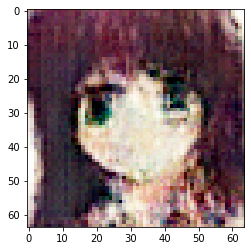

In [38]:
with torch.no_grad():
    plt.imshow(np.swapaxes(np.swapaxes(gen_imgs[0],0,2), 0, 1))

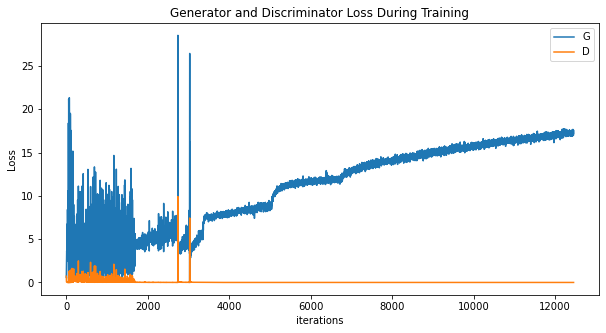

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()